In [1]:
%matplotlib notebook
import firedrake
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from hs_solver import *
from phi_solver import *
from model import *

# Introduction
This is a python notebook that details experiments with a 1D-subglacial hydrology model meant to represent the co-evolution of a connected channel-sheet water system based on the Glacier Drainage System model, GlaDS. This model represents the work of many previous studies including the work of Ian Hewitt, Mauro Werder, and Christian Schoof.
## Motivation
Subglacial hydrology beneath ice sheets is very difficult to observe and characterize directly, partially because the water system is very thin relative to the overlying column of kilometer thick ice. For this reason, most of what we know about subglacial hydrology at the ice sheet system scale comes from discharge observations and effective pressure measurements made beneath accessible moutain glaciers. The sampling-rate and data quality of ice sheet observing satallites now make it possible to measure large scale changes in subglacial hydrology manifest at the surface as changes in ice sheet elevation and horizontal velocity.

In Greenland, seasonal surface melt water has been observed to enhance surface velocities near the ice sheet margins by as much as $10-100$ m/yr. The importance of subglacial hydrology for understanding and predicting the evolution of ice sheets in a warming world is still widely debated and depends on the temporal/spatial resolution of the experiment and targeted goals of the study.

The simipliest kind of hydrology model requires three ingredients: 1) Description of water conservation. 2) Description of the hydraulic potential. 3) Time evolution of the drainage space (channel cross section, or sheet thickness). 

## Equations for water conservation
We assume in our model that water is incompressible and that the flux of water through any single node is equal to the flux out of that node plus local sources associated with local melting.

$\frac{dV}{dt} = Q_{in} - Q_{out} + M \Delta s$

## Hydraulic potential

The hydraulic potential beneath an ice sheet can be expressed as the sum of the pressure potential and the elevation potential:

$\phi = p_w + \rho_w g H$

where $H$ is the thickness of the water film.

## Time evolution of conduits (R-channels) and cavities (distributed sheets) 

Sheet and channel closing are both governed by the same process, creep closure, which reduces the size of cavities of thickness and channels of radius $h$ via the same equation:

$v_c(N,h) = Ah|N|^{n-1} N$

where $N$ is the effective pressure, which we can approximate as the difference between the overburden stress of the overlying ice $\phi_i$ and the  dydnamic hydropotential of the flow $\phi$. $n$ is the exponent in Glen's flow law, which we assume to be $3$.  

The mechanisms that govern the opening of channels and sheets are different. Distributed connected networks of cavities open via ice sliding over a bumpy bed:

$v_o(u_b,h) = \frac{u_b}{l_r} (h_r - h)$

where $u_b$ is the basal slip velocity (one of the mechanims by which ice dynamics feed back with the hydrology model), $l_r$ is the length scale of bed roughness, $h_r$ is the amplitude of bed roughness, and $h$ is the local thickness of the distributed cavity.

Channel opening is controlled by the exchange of potential energy in the turbulent flow with the icy side walls. The effects of Pressure melting can also lead to channel opening; however, the same pressure melting mechanism can also restrict channel formation, especially on retrograde bed slopes. The expressions for the channel opening (and occasional closing due to pressure melting) are:





# Initializing the model
First we need to call the mesh objects created for our shmip experiments and real glacier geometries. For more information on these experiments see the inputs directory and the mesh generation notebook.

# Motivated by discussion with Daniel.

Diverged line search error. Tuning parameter in petc that we need to change. The problem is well posed but the 

pde may evolve and then the pde is no longer well posed (this is a problem with the evolutions equations for the thickness and channel area equations most likely. 

notes on the git commit:

git rm -rf .ipynb_chpoints __pycache

create a that could be used to deal with this (there is one on the github website:

.gitignore




In [2]:
########### Domain Geometry SHMIP part 1: Greenland ############
proj_dir = '/Users/andrewhoffman/1Dhydrology/'

Lx = 100e3
nx =1000
b0=0.
W = 3000.
flux_condition = 0.0
mesh = firedrake.IntervalMesh(nx,Lx)
degree = 1
V_cg = firedrake.FunctionSpace(mesh,"CG",degree)

In [3]:
H=firedrake.Function(V_cg)
B=firedrake.Function(V_cg)
x = firedrake.SpatialCoordinate(mesh)
H=firedrake.interpolate(6*(firedrake.sqrt(firedrake.sqrt(x[0])+5000.)-firedrake.sqrt(firedrake.sqrt(5000.)))+firedrake.Constant(1.) ,V_cg)
B=firedrake.interpolate(firedrake.Constant(b0),V_cg)
width = firedrake.interpolate(firedrake.Constant(W),V_cg)
ub = firedrake.Function(V_cg)

#slip velocity and melt rate defined in the SHMIP experiment.
ub=firedrake.interpolate(firedrake.Constant(1e-6),V_cg)
m = firedrake.interpolate((firedrake.Constant(7.93e-11)),V_cg)

H_out = firedrake.File(proj_dir + "inputs/H.pvd")
B_out = firedrake.File(proj_dir + "inputs/B.pvd")

ub_out = firedrake.File(proj_dir + "inputs/ub.pvd")
m_out = firedrake.File(proj_dir + "inputs/m.pvd")

H_out.write(H)
B_out.write(B)
ub_out.write(ub)
m_out.write(m)

# Important input variables for SHMIP
The variable $m$ represents the combined fluxes associated with melt and any point sources in the mesh. This would include moulins (relavent for capturing feedbacks with surface melt on Greenland outlet glaciers and mountain glaciers) and the drainage of subglacial lakes (relavent for the Greenland near interior and Antarctic hydrology systems).

In [4]:
########### Model Initializtion ############


h_init = firedrake.Function(V_cg)
#h_init = firedrake.interpolate(.01/(1.0+x[0]),V_cg)
h_init = firedrake.interpolate(Constant(1e-9),V_cg)

S_init = firedrake.Function(V_cg)
#S_init = firedrake.interpolate((.01*((50e3+1)-x[0])/50e3),V_cg)

phi_init = firedrake.Function(V_cg)

phi_init=pcs['g']*H*pcs['rho_ice'];

In [5]:
# Load potential at 0 pressure
phi_m = firedrake.Function(V_cg)
phi_m = B*pcs['g']*pcs['rho_water']
# Ice overburden pressure
p_i = firedrake.Function(V_cg)
p_i = H*pcs['g']*pcs['rho_ice']+firedrake.Constant(.001)
# Enforce 0 pressure bc at margin
bc = firedrake.DirichletBC(V_cg, phi_m+p_i,1)

# Initialize hydropotential
phi_init=firedrake.Function(V_cg)
phi_init=phi_m+p_i
#pcs['k'] = firedrake.Constant(5e-4)
#pcs['k_c'] = firedrake.Constant(0.05)


In [6]:
model_inputs = {}
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_m + p_i
model_inputs['mesh'] = mesh
model_inputs['H'] = H
model_inputs['B'] = B
model_inputs['u_b'] = ub
model_inputs['m'] = m
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['width'] = width
model_inputs['out_dir'] = proj_dir + "outputs/"
model_inputs['constants'] = pcs

In [7]:
# Create the Glads model
model = Glads1DModel(model_inputs)
# End time
T = 5.0*pcs['spd']
# Time step
dt = 60.0* 30

# Geometries and inputs
Before we identify any steady state behavior in the model, we first plot the geometries of our synthetic glacier with the initial condition for channel and sheet geometry, and the melt water input that will load the system for the duration of the simulation.

<IPython.core.display.Javascript object>


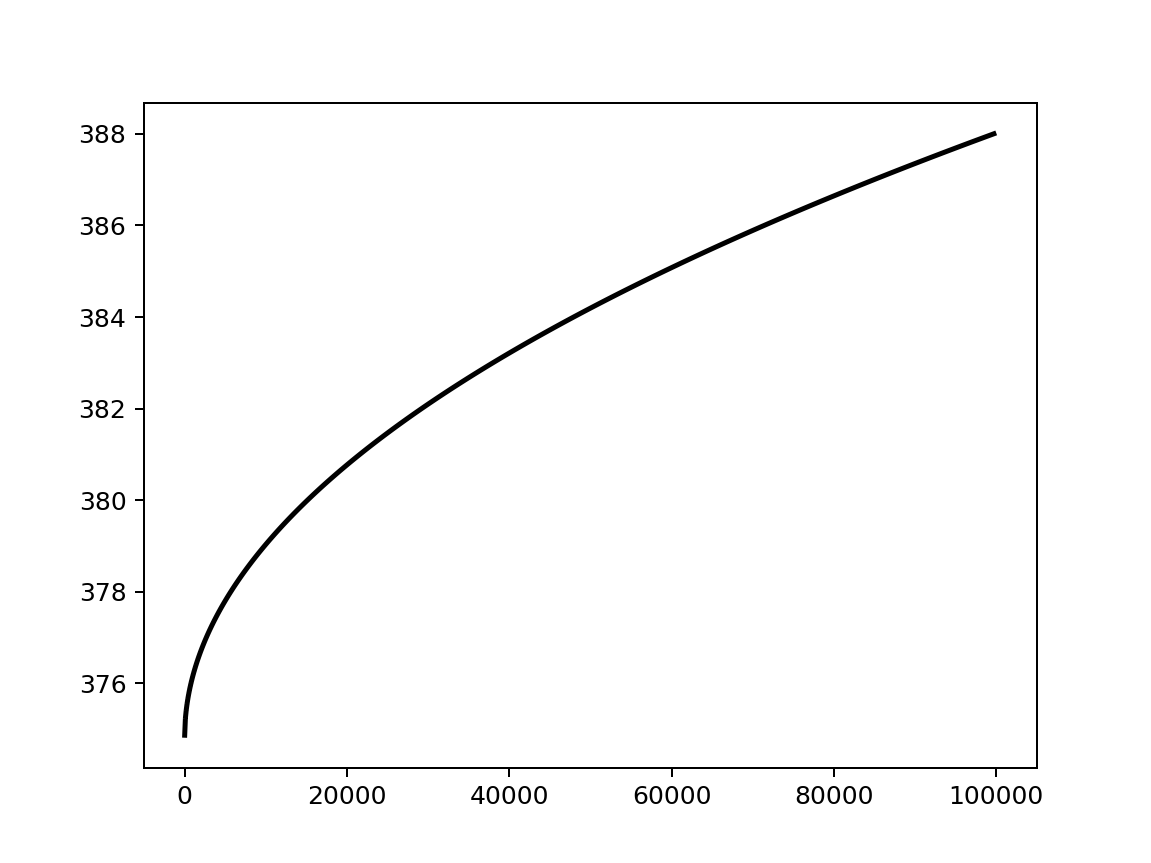

<IPython.core.display.Javascript object>


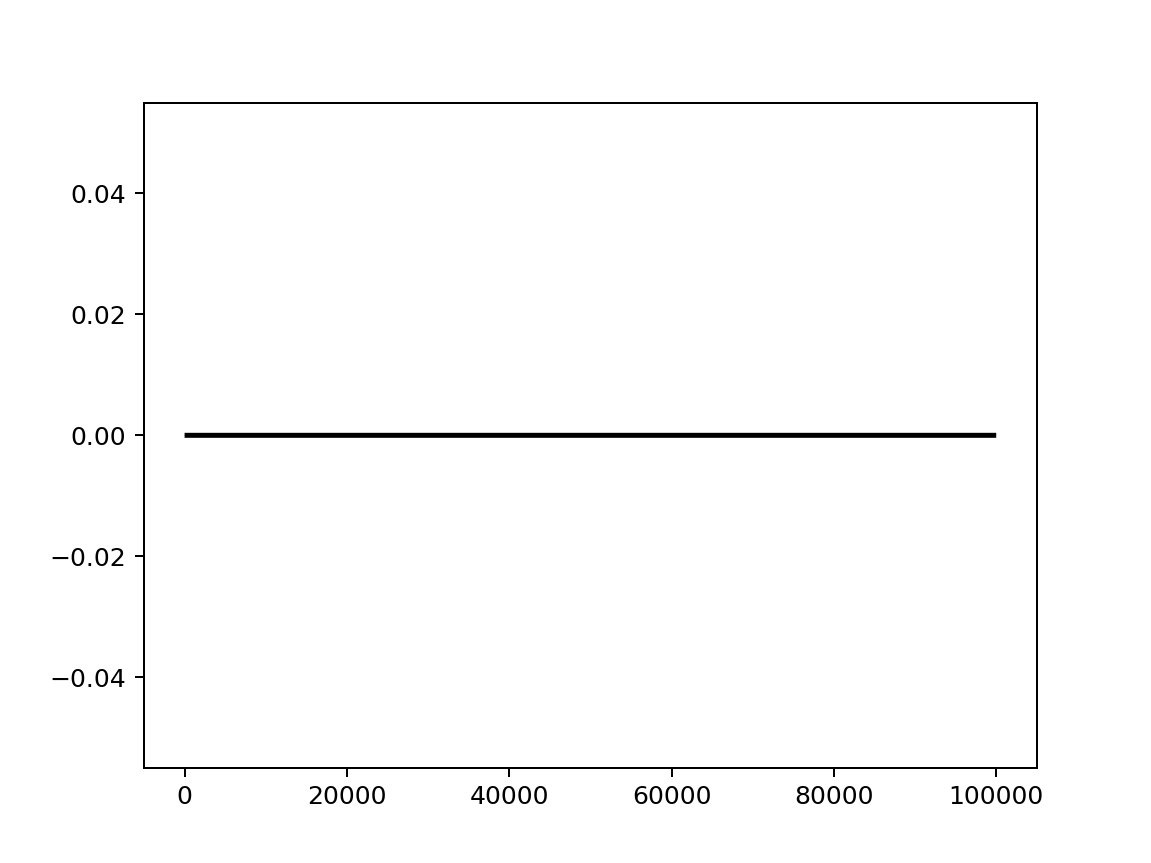

<IPython.core.display.Javascript object>


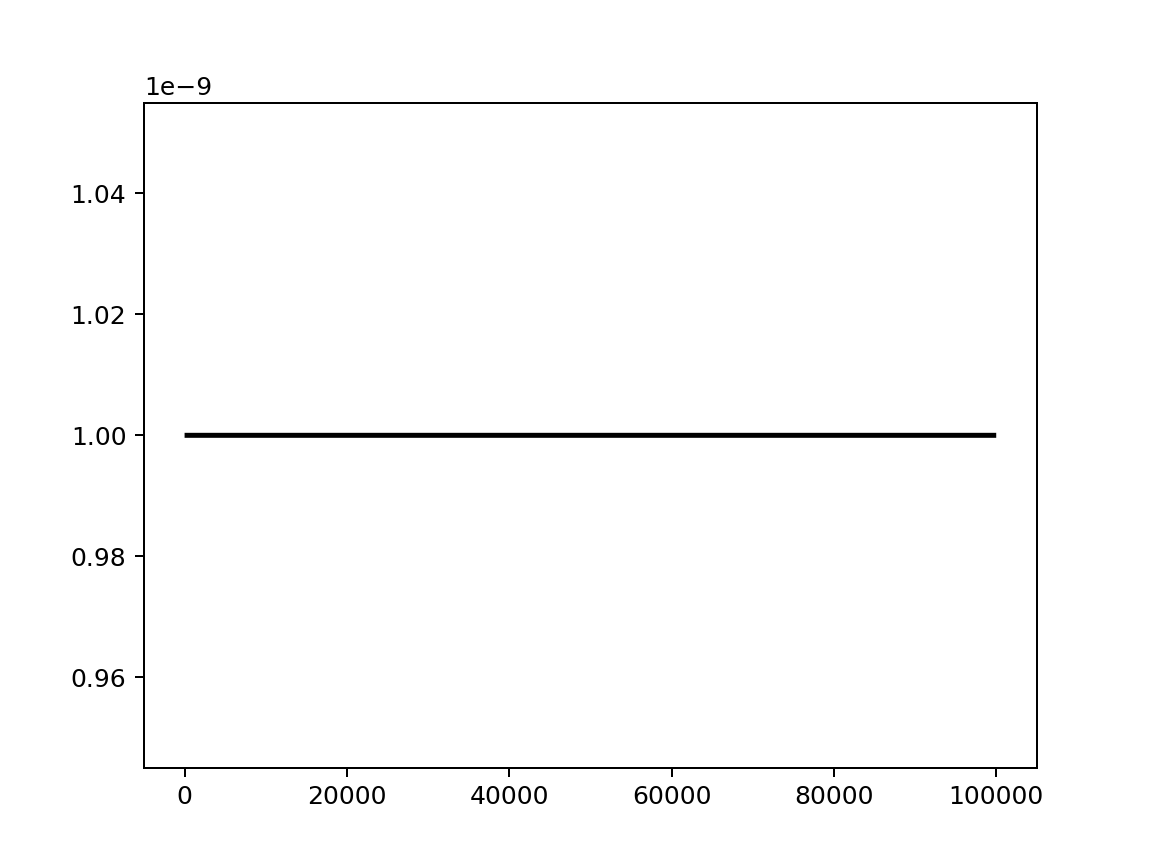

<IPython.core.display.Javascript object>


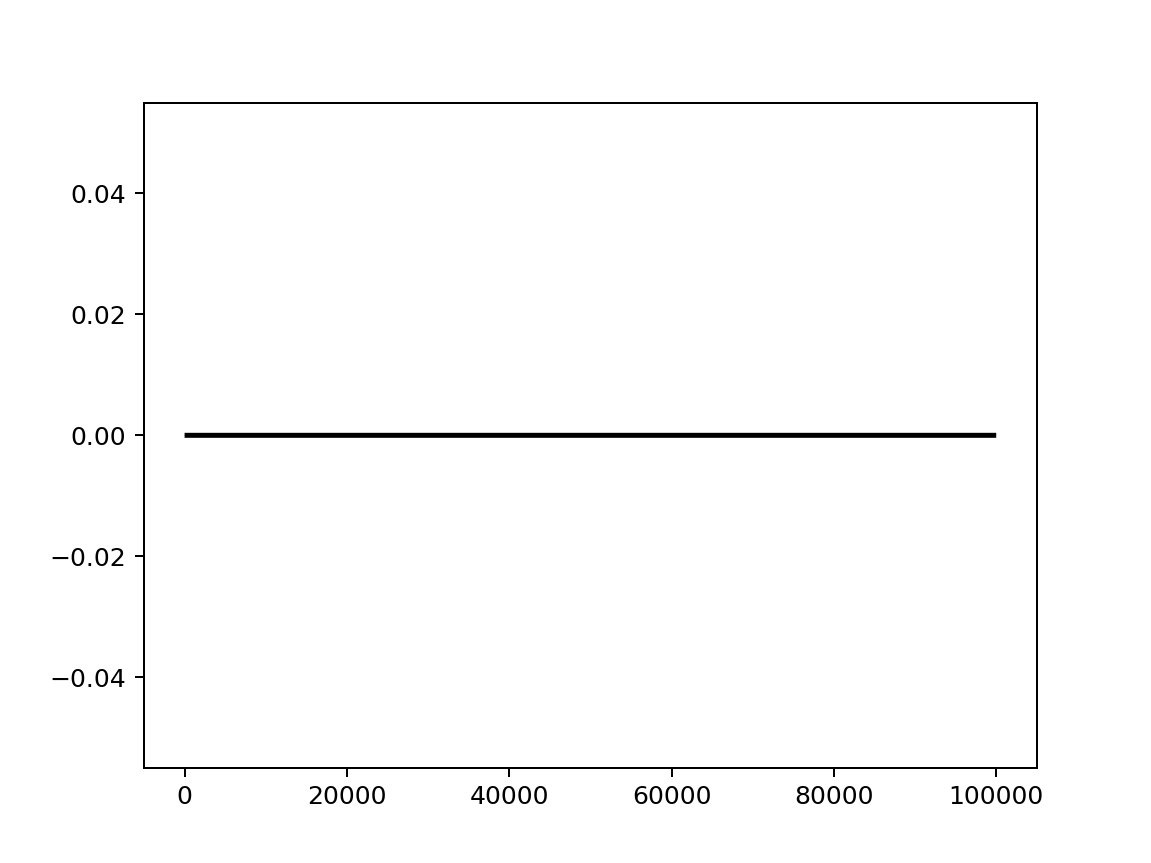

<IPython.core.display.Javascript object>


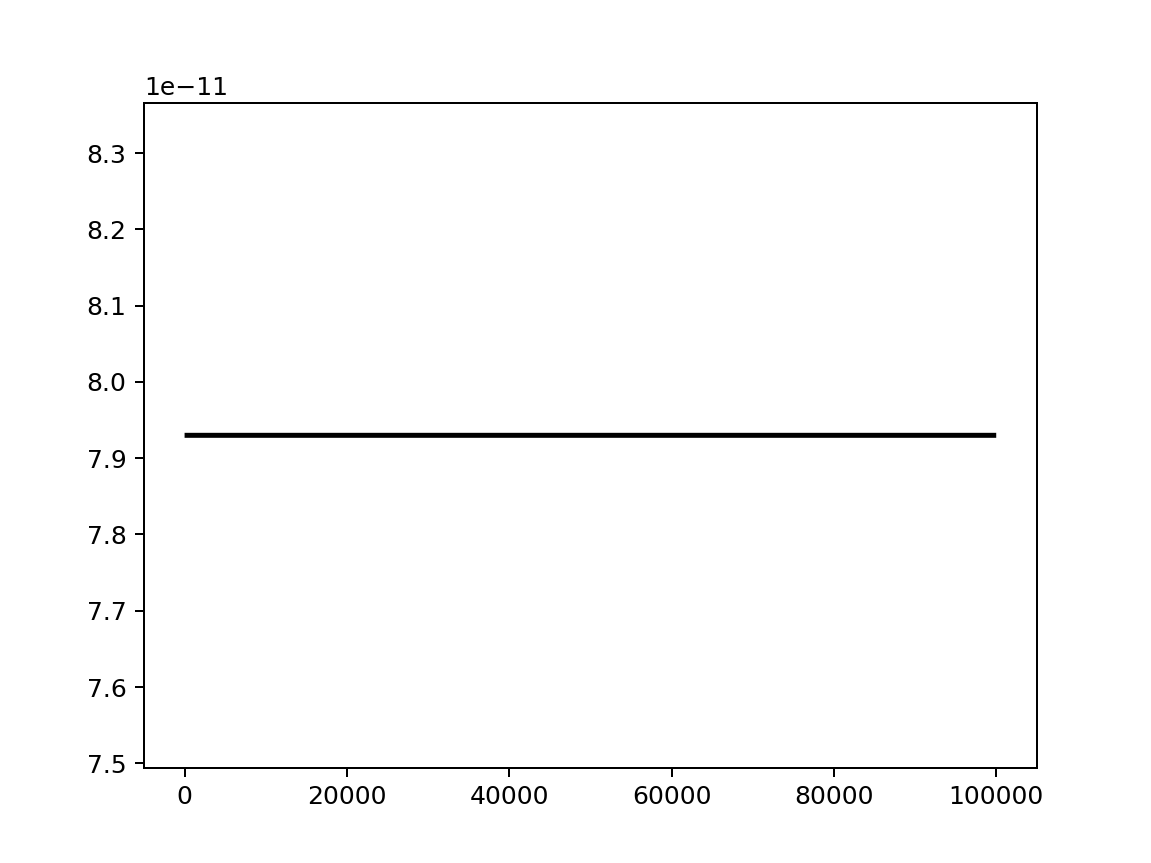

In [8]:

plot(model.H)
plot(model.B)
plot(model.h)
plot(model.S)
plot(model.m)


1800.0
3600.0
5400.0
7200.0
9000.0
10800.0
12600.0
14400.0
16200.0
18000.0
19800.0
21600.0
23400.0
25200.0
27000.0
28800.0
30600.0
32400.0
34200.0
36000.0
37800.0
39600.0
41400.0
43200.0
45000.0
46800.0
48600.0
50400.0
52200.0
54000.0
55800.0
57600.0
59400.0
61200.0
63000.0
64800.0
66600.0
68400.0
70200.0
72000.0
73800.0
75600.0
77400.0
79200.0
81000.0
82800.0
84600.0
86400.0


<IPython.core.display.Javascript object>


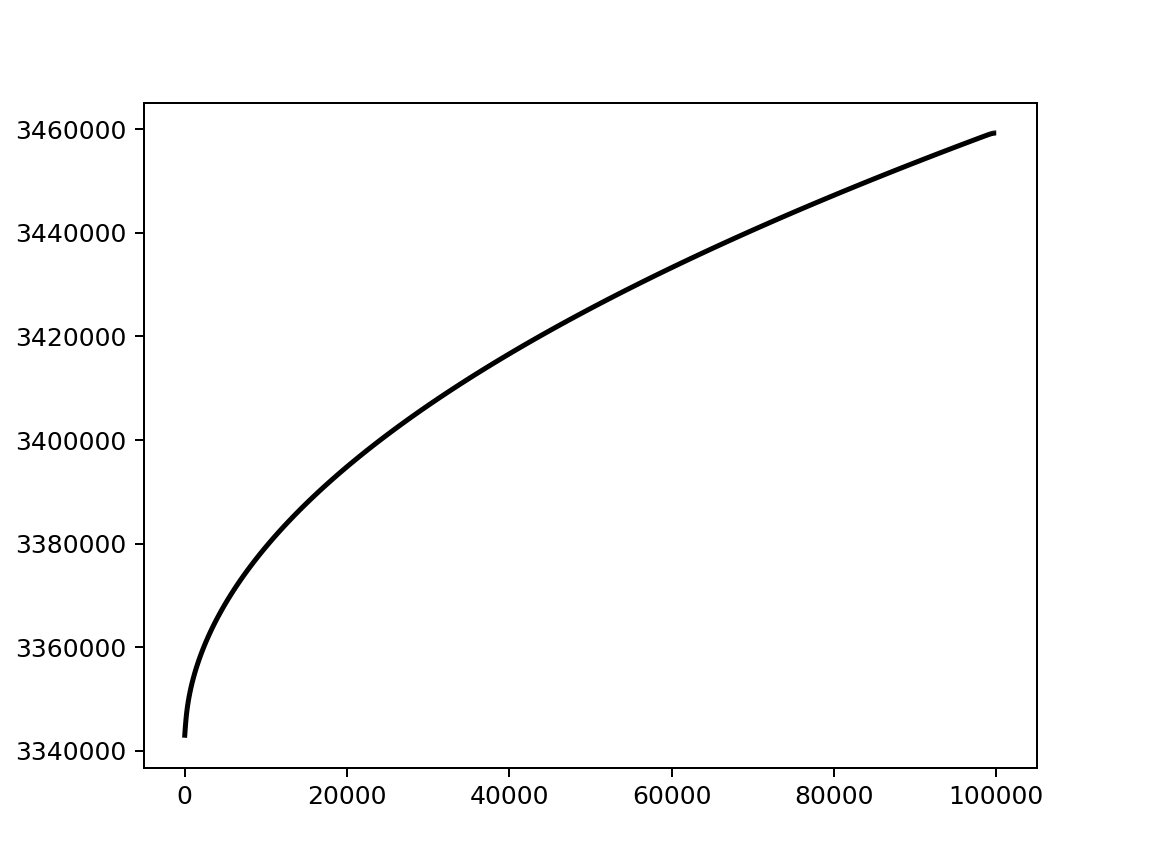

88200.0
90000.0
91800.0
93600.0
95400.0
97200.0
99000.0
100800.0
102600.0
104400.0
106200.0
108000.0
109800.0
111600.0
113400.0
115200.0
117000.0
118800.0
120600.0
122400.0
124200.0
126000.0
127800.0
129600.0
131400.0
133200.0
135000.0
136800.0
138600.0
140400.0
142200.0
144000.0
145800.0
147600.0
149400.0
151200.0
153000.0
154800.0
156600.0
158400.0
160200.0
162000.0
163800.0
165600.0
167400.0
169200.0
171000.0
172800.0


<IPython.core.display.Javascript object>


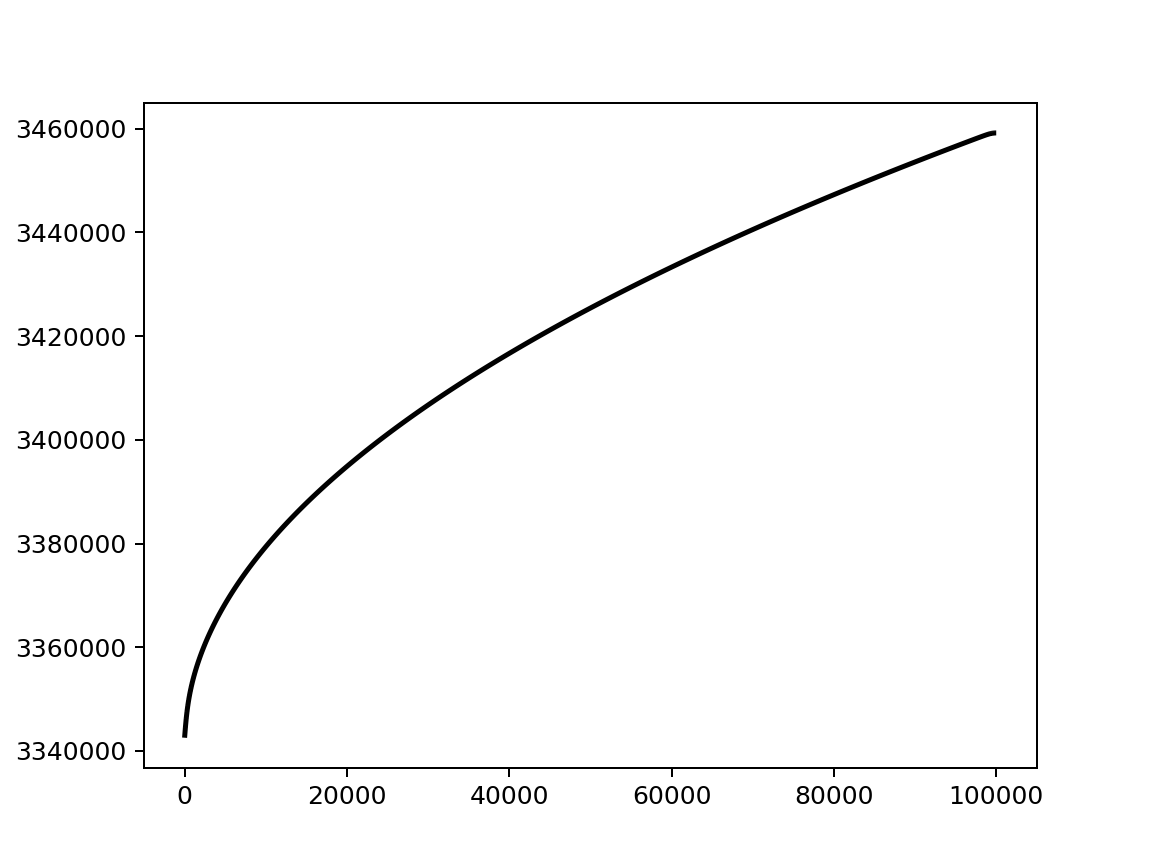

174600.0
176400.0
178200.0
180000.0
181800.0
183600.0
185400.0
187200.0
189000.0
190800.0
192600.0
194400.0
196200.0
198000.0
199800.0
201600.0
203400.0
205200.0
207000.0
208800.0
210600.0
212400.0
214200.0
216000.0
217800.0
219600.0
221400.0
223200.0
225000.0
226800.0
228600.0
230400.0
232200.0
234000.0
235800.0
237600.0
239400.0
241200.0
243000.0
244800.0
246600.0
248400.0
250200.0
252000.0
253800.0
255600.0
257400.0
259200.0


<IPython.core.display.Javascript object>

261000.0
262800.0
264600.0
266400.0
268200.0
270000.0
271800.0
273600.0
275400.0
277200.0
279000.0
280800.0
282600.0
284400.0
286200.0
288000.0
289800.0
291600.0
293400.0
295200.0
297000.0
298800.0
300600.0
302400.0
304200.0
306000.0
307800.0
309600.0
311400.0
313200.0
315000.0
316800.0
318600.0
320400.0
322200.0
324000.0
325800.0
327600.0
329400.0
331200.0
333000.0
334800.0
336600.0
338400.0
340200.0
342000.0
343800.0
345600.0


<IPython.core.display.Javascript object>


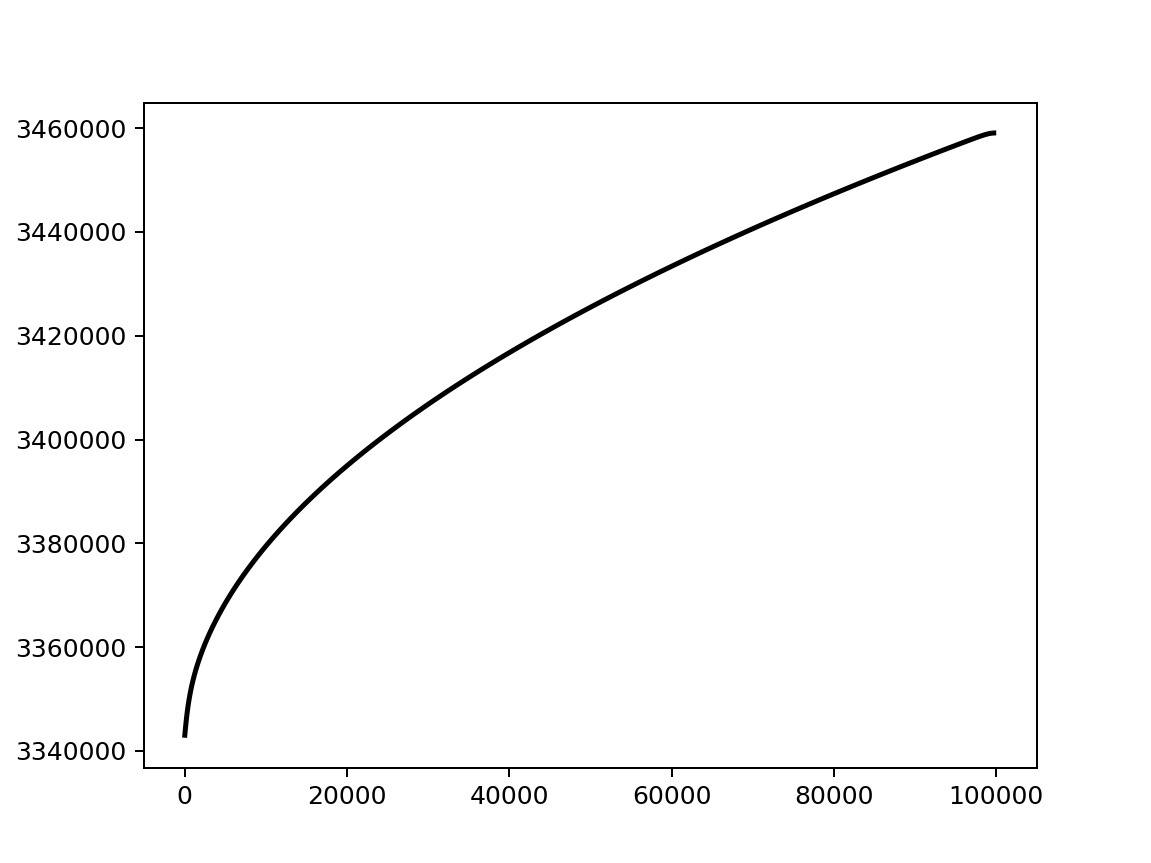

347400.0
349200.0
351000.0
352800.0
354600.0
356400.0
358200.0
360000.0
361800.0
363600.0
365400.0
367200.0
369000.0
370800.0
372600.0
374400.0
376200.0
378000.0
379800.0
381600.0
383400.0
385200.0
387000.0
388800.0
390600.0
392400.0
394200.0
396000.0
397800.0
399600.0
401400.0
403200.0
405000.0
406800.0
408600.0
410400.0
412200.0
414000.0
415800.0
417600.0
419400.0
421200.0
423000.0
424800.0
426600.0
428400.0
430200.0
432000.0


<IPython.core.display.Javascript object>


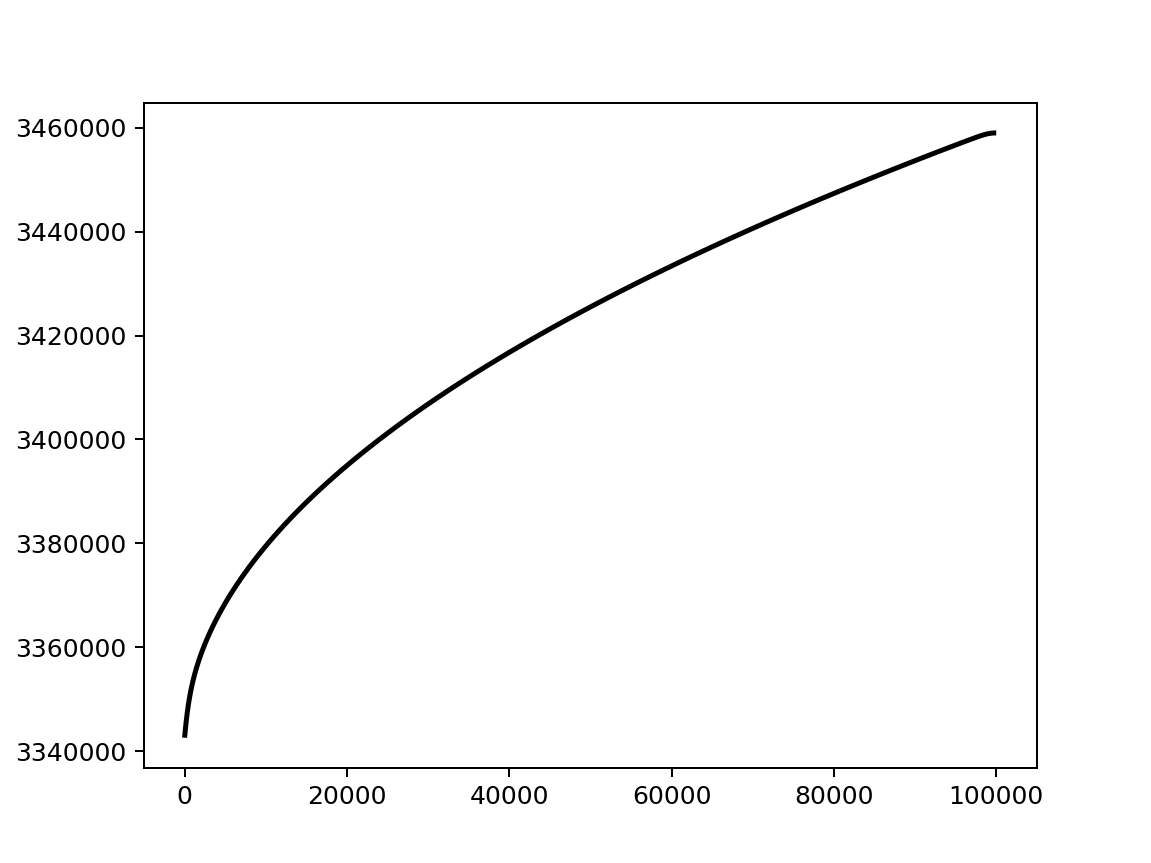

433800.0
435600.0
437400.0
439200.0
441000.0
442800.0
444600.0
446400.0
448200.0
450000.0
451800.0
453600.0
455400.0
457200.0
459000.0
460800.0
462600.0
464400.0
466200.0
468000.0
469800.0
471600.0
473400.0
475200.0
477000.0
478800.0
480600.0
482400.0
484200.0
486000.0
487800.0
489600.0
491400.0
493200.0
495000.0
496800.0
498600.0
500400.0
502200.0
504000.0
505800.0
507600.0
509400.0
511200.0
513000.0
514800.0
516600.0
518400.0


<IPython.core.display.Javascript object>


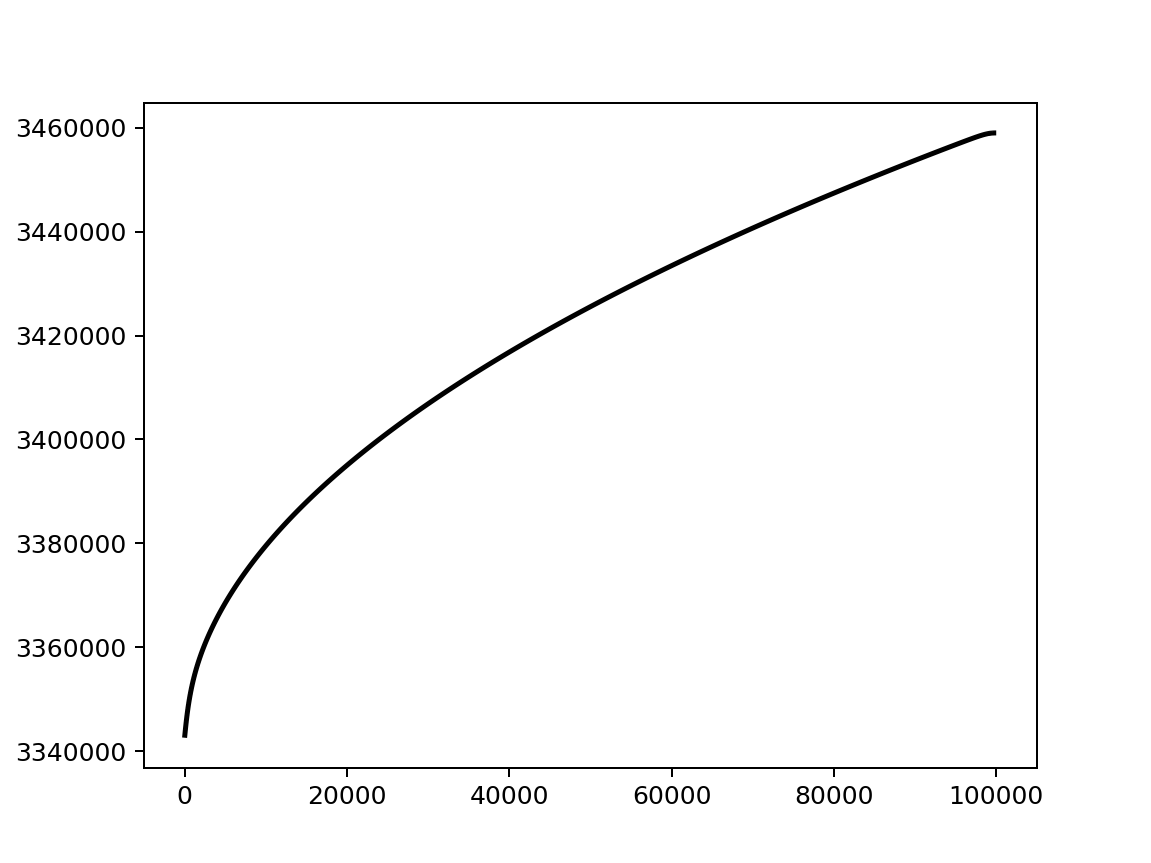

520200.0
522000.0
523800.0
525600.0
527400.0
529200.0
531000.0
532800.0
534600.0
536400.0
538200.0
540000.0
541800.0
543600.0
545400.0
547200.0
549000.0
550800.0
552600.0
554400.0
556200.0
558000.0
559800.0
561600.0
563400.0
565200.0
567000.0
568800.0
570600.0
572400.0
574200.0
576000.0
577800.0
579600.0
581400.0
583200.0
585000.0
586800.0
588600.0
590400.0
592200.0
594000.0
595800.0
597600.0
599400.0
601200.0
603000.0
604800.0


<IPython.core.display.Javascript object>

606600.0
608400.0
610200.0
612000.0
613800.0
615600.0
617400.0
619200.0
621000.0
622800.0
624600.0
626400.0
628200.0
630000.0
631800.0
633600.0
635400.0
637200.0
639000.0
640800.0
642600.0
644400.0
646200.0
648000.0
649800.0
651600.0
653400.0
655200.0
657000.0
658800.0
660600.0
662400.0
664200.0
666000.0
667800.0
669600.0
671400.0
673200.0
675000.0
676800.0
678600.0
680400.0
682200.0
684000.0
685800.0
687600.0
689400.0
691200.0


<IPython.core.display.Javascript object>


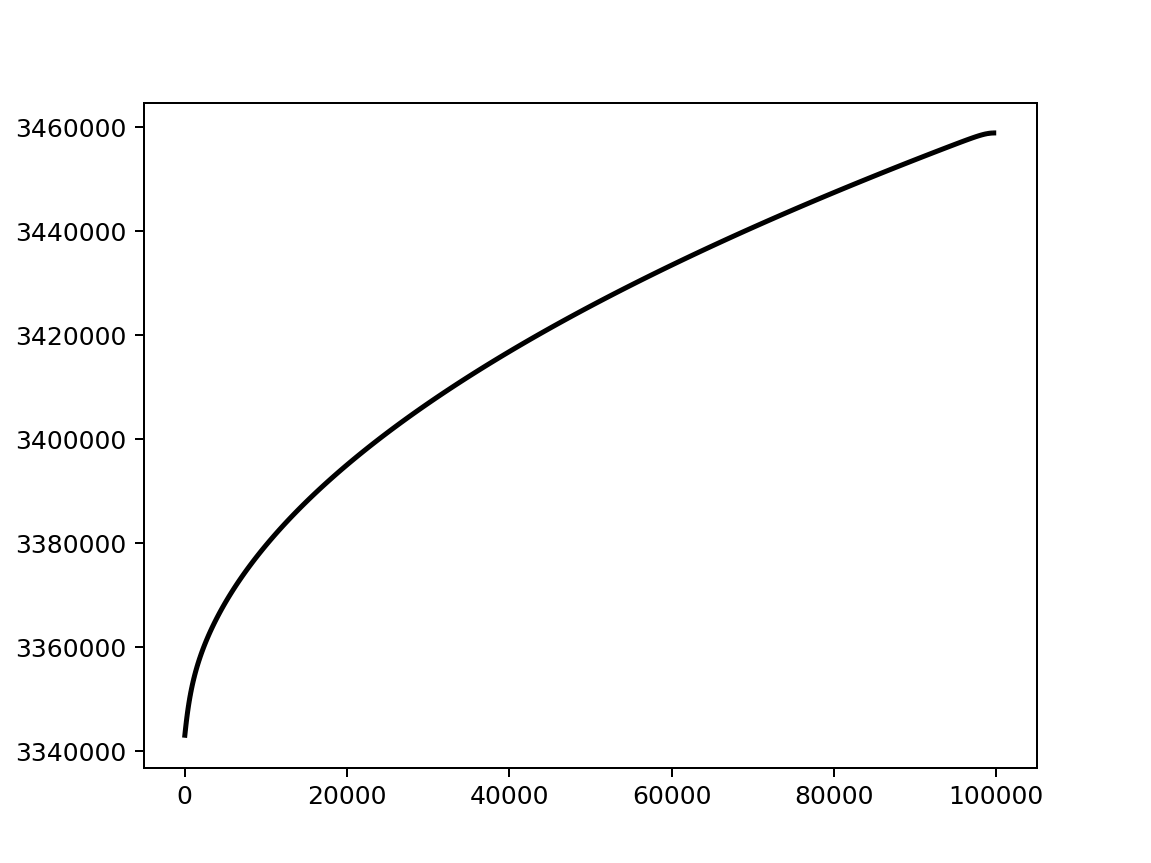

693000.0
694800.0
696600.0
698400.0
700200.0
702000.0
703800.0
705600.0
707400.0
709200.0
711000.0
712800.0
714600.0
716400.0
718200.0
720000.0
721800.0
723600.0
725400.0
727200.0
729000.0
730800.0
732600.0
734400.0
736200.0
738000.0
739800.0
741600.0
743400.0
745200.0
747000.0
748800.0
750600.0
752400.0
754200.0
756000.0
757800.0
759600.0
761400.0
763200.0
765000.0
766800.0
768600.0
770400.0
772200.0
774000.0
775800.0
777600.0


<IPython.core.display.Javascript object>


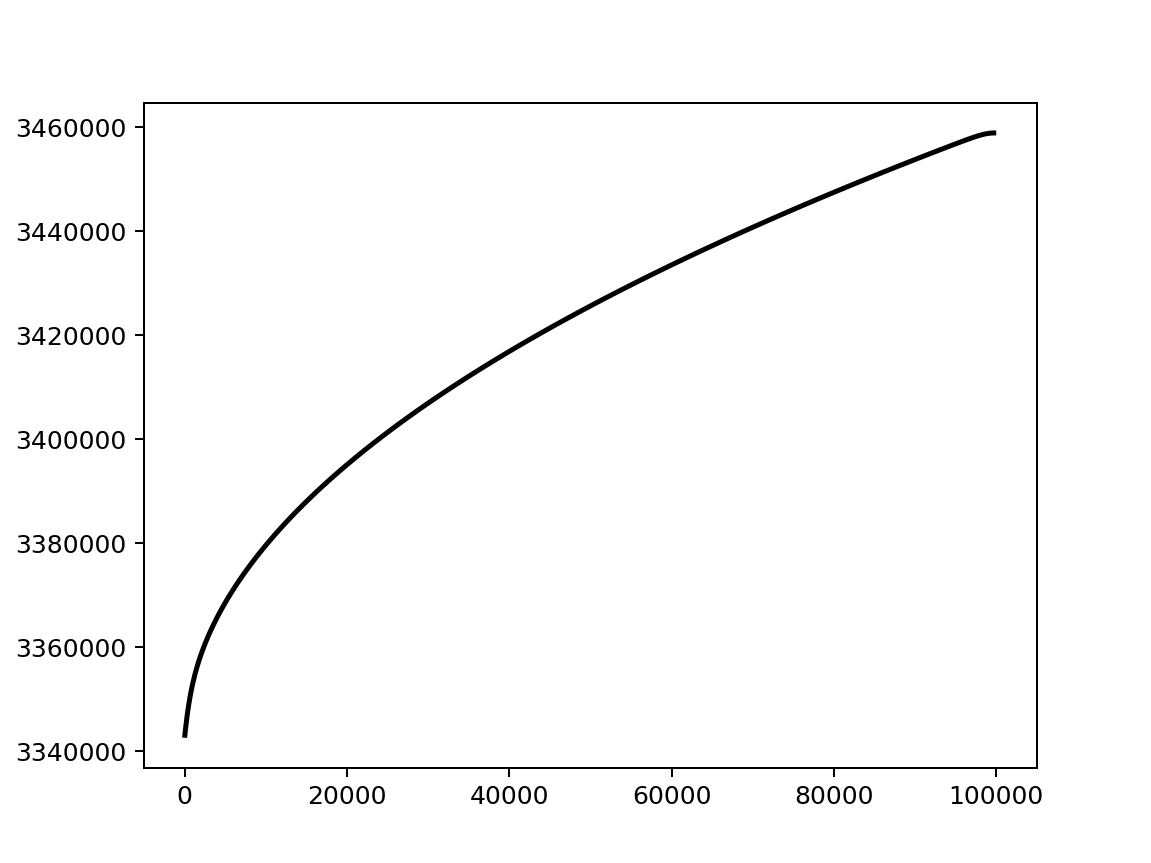

779400.0
781200.0
783000.0
784800.0
786600.0
788400.0
790200.0
792000.0
793800.0
795600.0
797400.0
799200.0
801000.0
802800.0
804600.0
806400.0
808200.0
810000.0
811800.0
813600.0
815400.0
817200.0
819000.0
820800.0
822600.0
824400.0
826200.0
828000.0
829800.0
831600.0
833400.0
835200.0
837000.0
838800.0
840600.0
842400.0
844200.0
846000.0
847800.0
849600.0
851400.0
853200.0
855000.0
856800.0
858600.0
860400.0
862200.0
864000.0


<IPython.core.display.Javascript object>

865800.0
867600.0
869400.0
871200.0
873000.0
874800.0
876600.0
878400.0
880200.0
882000.0
883800.0
885600.0
887400.0
889200.0
891000.0
892800.0
894600.0
896400.0
898200.0
900000.0
901800.0
903600.0
905400.0
907200.0
909000.0
910800.0
912600.0
914400.0
916200.0
918000.0
919800.0
921600.0
923400.0
925200.0
927000.0
928800.0
930600.0
932400.0
934200.0
936000.0
937800.0
939600.0
941400.0
943200.0
945000.0
946800.0
948600.0
950400.0


<IPython.core.display.Javascript object>


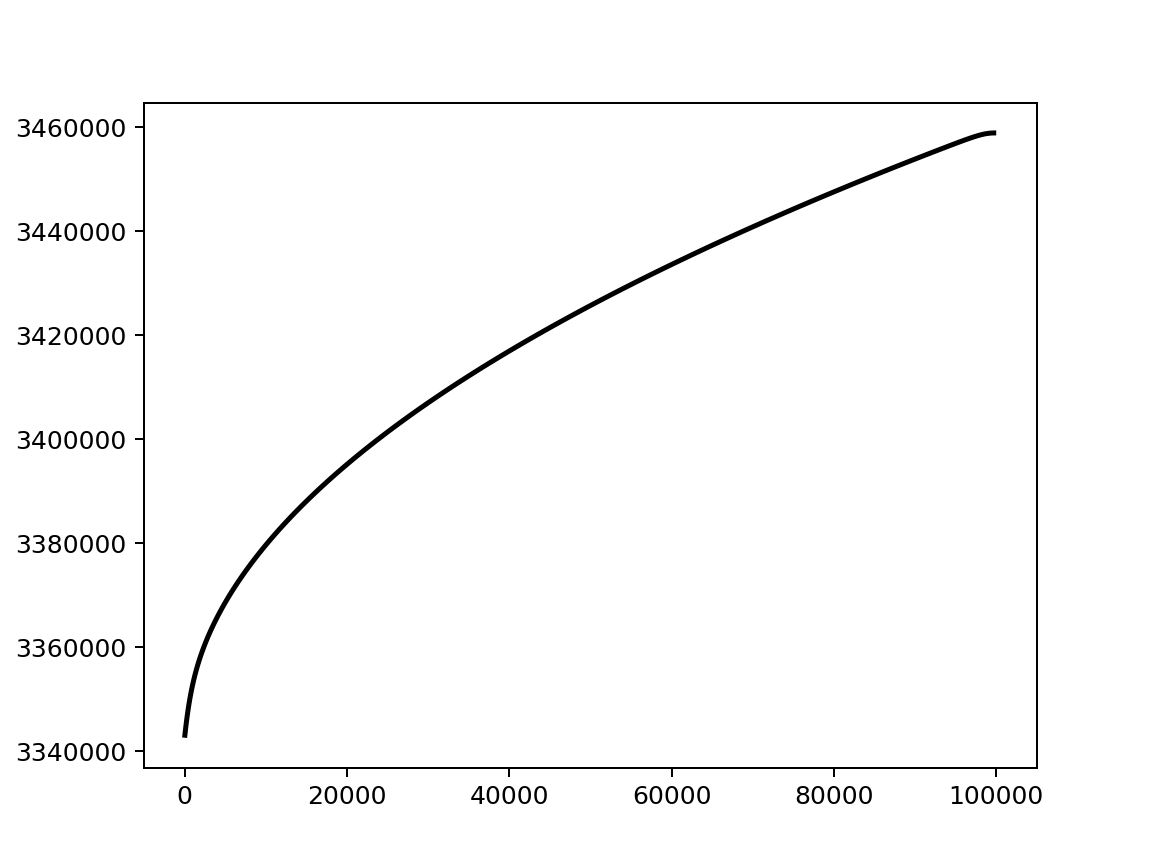

952200.0
954000.0
955800.0
957600.0
959400.0
961200.0
963000.0
964800.0
966600.0
968400.0
970200.0
972000.0
973800.0
975600.0
977400.0
979200.0
981000.0
982800.0
984600.0
986400.0
988200.0
990000.0
991800.0
993600.0
995400.0
997200.0
999000.0
1000800.0
1002600.0
1004400.0
1006200.0
1008000.0
1009800.0
1011600.0
1013400.0
1015200.0
1017000.0
1018800.0
1020600.0
1022400.0
1024200.0
1026000.0
1027800.0
1029600.0
1031400.0
1033200.0
1035000.0
1036800.0


<IPython.core.display.Javascript object>


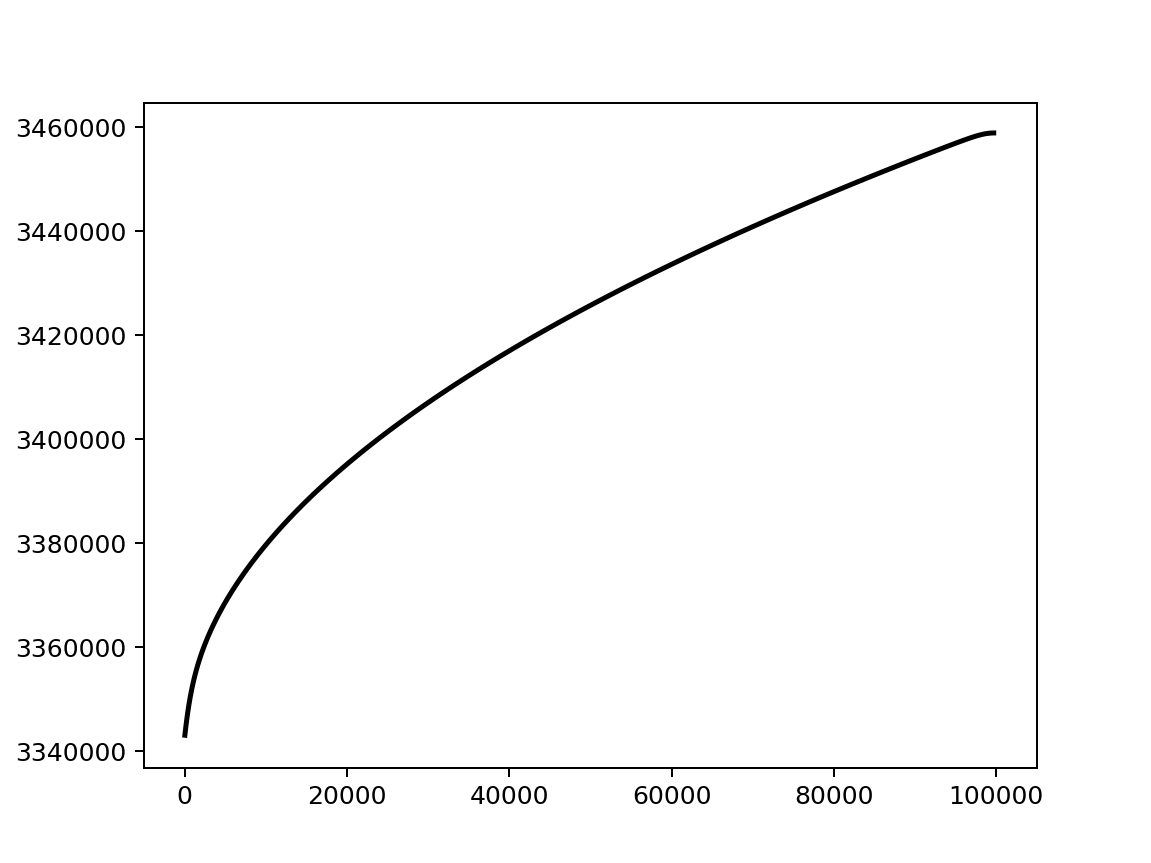

1038600.0
1040400.0
1042200.0
1044000.0
1045800.0
1047600.0
1049400.0
1051200.0
1053000.0
1054800.0
1056600.0
1058400.0
1060200.0
1062000.0
1063800.0
1065600.0
1067400.0
1069200.0
1071000.0
1072800.0
1074600.0
1076400.0
1078200.0
1080000.0
1081800.0
1083600.0
1085400.0
1087200.0
1089000.0
1090800.0
1092600.0
1094400.0
1096200.0
1098000.0
1099800.0
1101600.0
1103400.0
1105200.0
1107000.0
1108800.0
1110600.0
1112400.0
1114200.0
1116000.0
1117800.0
1119600.0
1121400.0
1123200.0


<IPython.core.display.Javascript object>


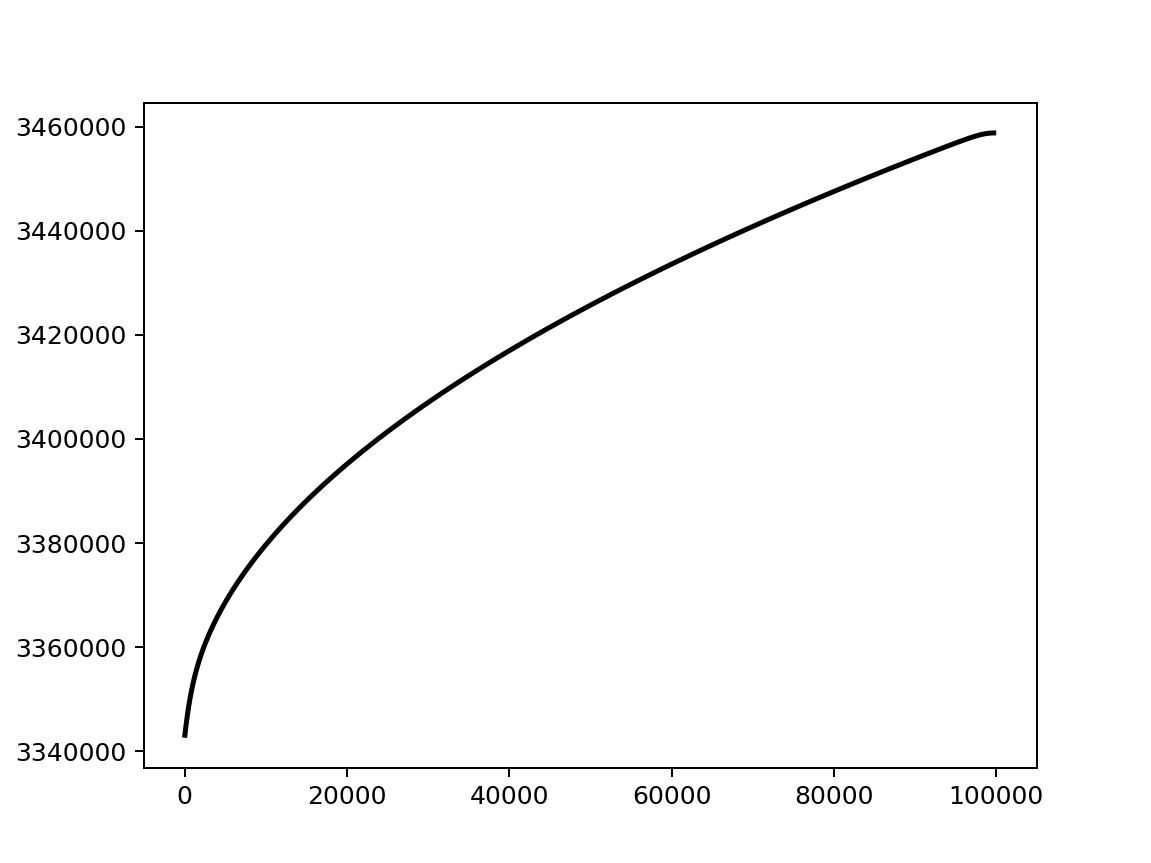

1125000.0
1126800.0
1128600.0
1130400.0
1132200.0
1134000.0
1135800.0
1137600.0
1139400.0
1141200.0
1143000.0
1144800.0
1146600.0
1148400.0
1150200.0
1152000.0
1153800.0
1155600.0
1157400.0
1159200.0
1161000.0
1162800.0
1164600.0
1166400.0
1168200.0
1170000.0
1171800.0
1173600.0
1175400.0
1177200.0
1179000.0
1180800.0
1182600.0
1184400.0
1186200.0
1188000.0
1189800.0
1191600.0
1193400.0
1195200.0
1197000.0
1198800.0
1200600.0
1202400.0
1204200.0
1206000.0
1207800.0
1209600.0


<IPython.core.display.Javascript object>

1211400.0
1213200.0
1215000.0
1216800.0
1218600.0
1220400.0
1222200.0
1224000.0
1225800.0
1227600.0
1229400.0
1231200.0
1233000.0
1234800.0
1236600.0
1238400.0
1240200.0
1242000.0
1243800.0
1245600.0
1247400.0
1249200.0
1251000.0
1252800.0
1254600.0
1256400.0
1258200.0
1260000.0
1261800.0
1263600.0
1265400.0
1267200.0
1269000.0
1270800.0
1272600.0
1274400.0
1276200.0
1278000.0
1279800.0
1281600.0
1283400.0
1285200.0
1287000.0
1288800.0
1290600.0
1292400.0
1294200.0
1296000.0


<IPython.core.display.Javascript object>

1297800.0
1299600.0
1301400.0
1303200.0
1305000.0
1306800.0
1308600.0
1310400.0
1312200.0
1314000.0
1315800.0
1317600.0
1319400.0
1321200.0
1323000.0
1324800.0
1326600.0
1328400.0
1330200.0
1332000.0
1333800.0
1335600.0
1337400.0
1339200.0
1341000.0
1342800.0
1344600.0
1346400.0
1348200.0
1350000.0
1351800.0
1353600.0
1355400.0
1357200.0
1359000.0
1360800.0
1362600.0
1364400.0
1366200.0
1368000.0
1369800.0
1371600.0
1373400.0
1375200.0
1377000.0
1378800.0
1380600.0
1382400.0


/Applications/firedrake/firedrake/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

1384200.0
1386000.0
1387800.0
1389600.0
1391400.0
1393200.0
1395000.0
1396800.0
1398600.0
1400400.0
1402200.0
1404000.0
1405800.0
1407600.0
1409400.0
1411200.0
1413000.0
1414800.0
1416600.0
1418400.0
1420200.0
1422000.0
1423800.0
1425600.0
1427400.0
1429200.0
1431000.0
1432800.0
1434600.0
1436400.0
1438200.0
1440000.0
1441800.0
1443600.0
1445400.0
1447200.0
1449000.0
1450800.0
1452600.0
1454400.0
1456200.0
1458000.0
1459800.0
1461600.0
1463400.0
1465200.0
1467000.0
1468800.0


<IPython.core.display.Javascript object>


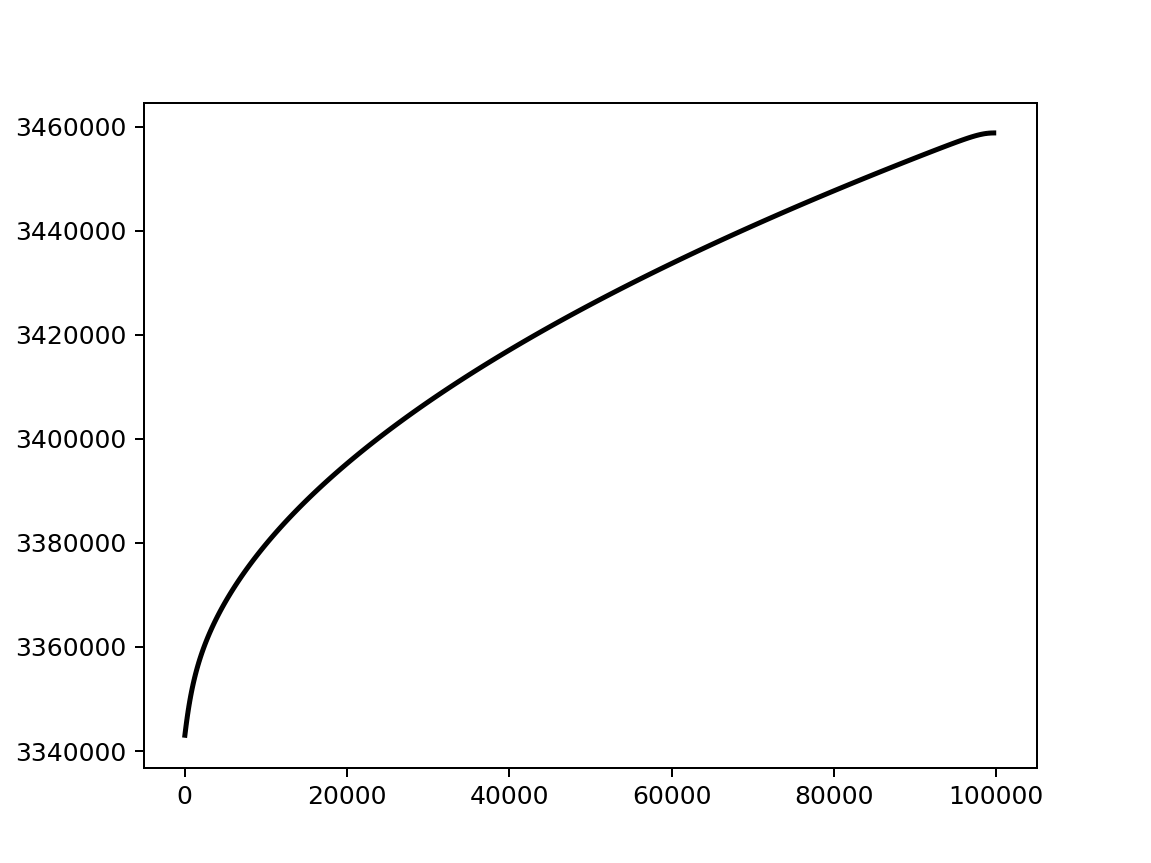

1470600.0
1472400.0
1474200.0
1476000.0
1477800.0
1479600.0
1481400.0
1483200.0
1485000.0
1486800.0
1488600.0
1490400.0
1492200.0
1494000.0
1495800.0
1497600.0
1499400.0
1501200.0
1503000.0
1504800.0
1506600.0
1508400.0
1510200.0
1512000.0
1513800.0
1515600.0
1517400.0
1519200.0
1521000.0
1522800.0
1524600.0
1526400.0
1528200.0
1530000.0
1531800.0
1533600.0
1535400.0
1537200.0
1539000.0
1540800.0
1542600.0
1544400.0
1546200.0
1548000.0
1549800.0
1551600.0
1553400.0
1555200.0


<IPython.core.display.Javascript object>


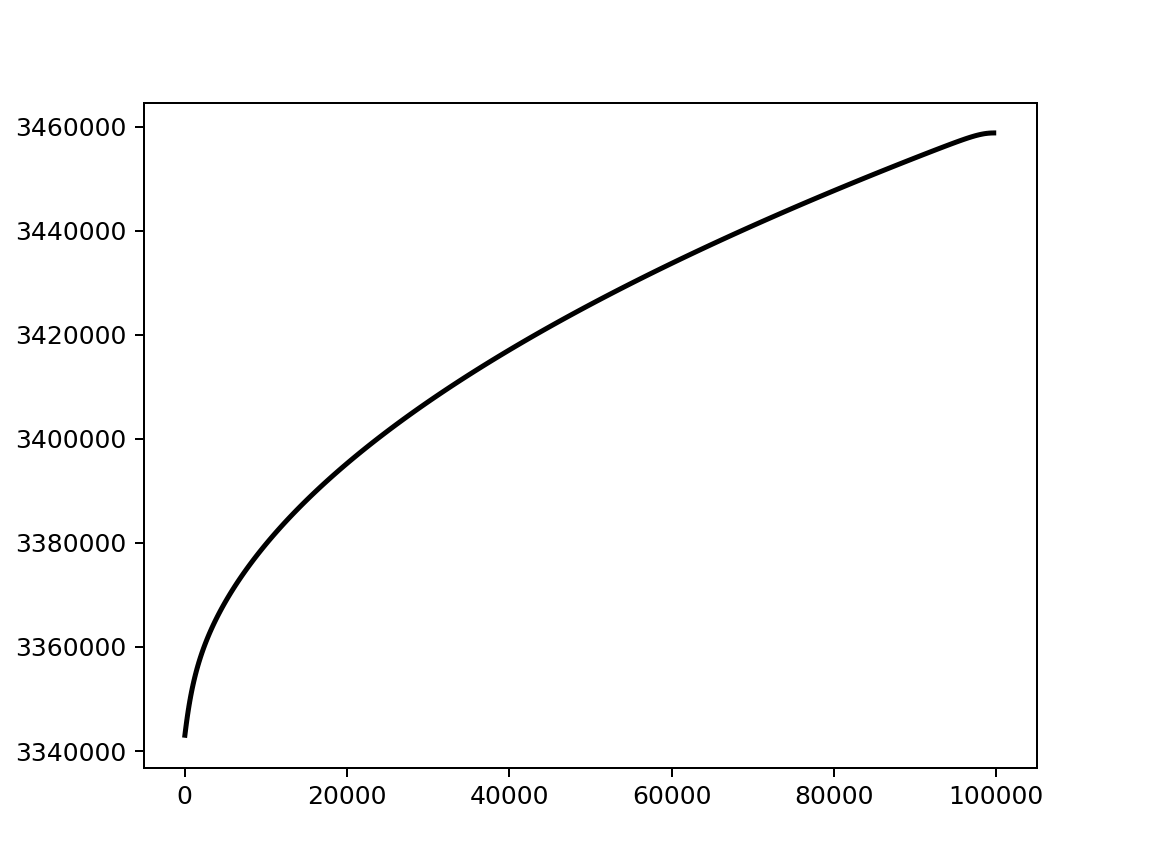

1557000.0
1558800.0
1560600.0
1562400.0
1564200.0
1566000.0
1567800.0
1569600.0
1571400.0
1573200.0
1575000.0
1576800.0
1578600.0
1580400.0
1582200.0
1584000.0
1585800.0
1587600.0
1589400.0
1591200.0
1593000.0
1594800.0
1596600.0
1598400.0
1600200.0
1602000.0
1603800.0
1605600.0
1607400.0
1609200.0
1611000.0
1612800.0
1614600.0
1616400.0
1618200.0
1620000.0
1621800.0
1623600.0
1625400.0
1627200.0
1629000.0
1630800.0
1632600.0
1634400.0
1636200.0
1638000.0
1639800.0
1641600.0


<IPython.core.display.Javascript object>


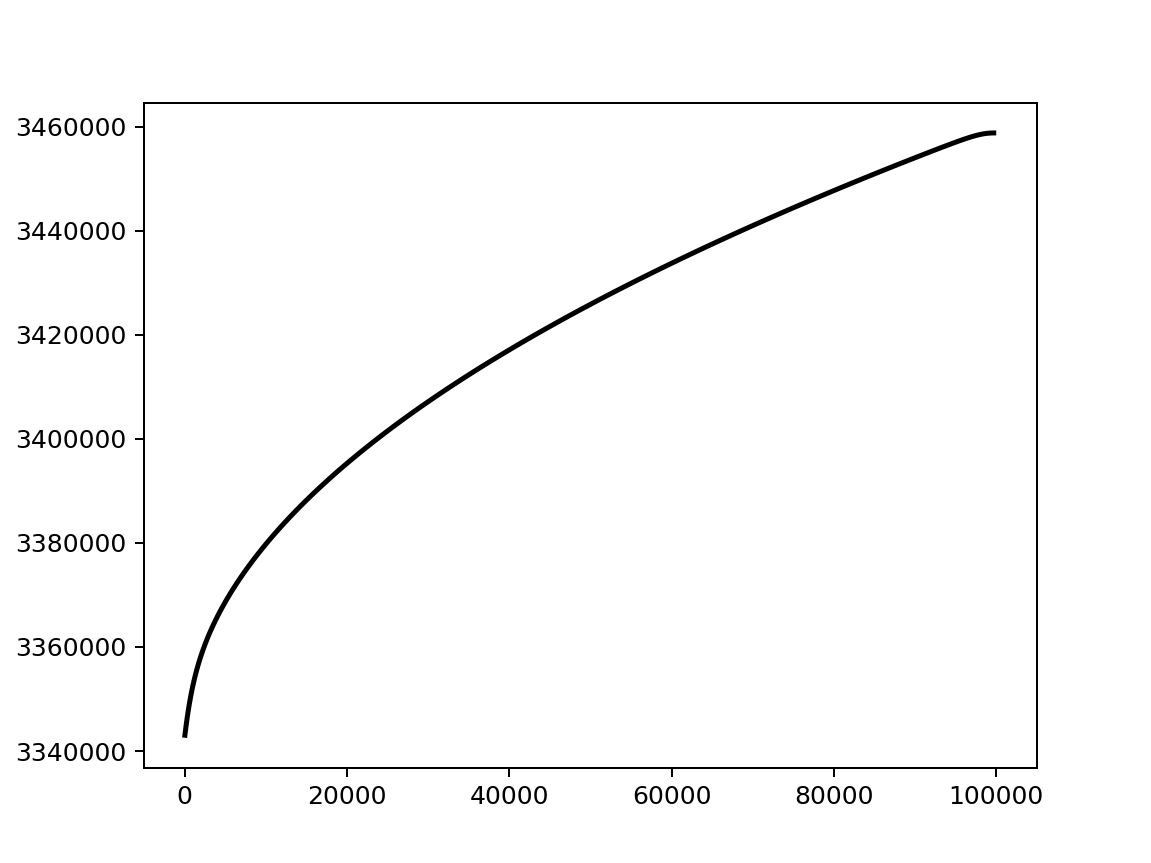

1643400.0
1645200.0
1647000.0
1648800.0
1650600.0
1652400.0
1654200.0
1656000.0
1657800.0
1659600.0
1661400.0
1663200.0
1665000.0
1666800.0
1668600.0
1670400.0
1672200.0
1674000.0
1675800.0
1677600.0
1679400.0
1681200.0
1683000.0
1684800.0
1686600.0
1688400.0
1690200.0
1692000.0
1693800.0
1695600.0
1697400.0
1699200.0
1701000.0
1702800.0
1704600.0
1706400.0
1708200.0
1710000.0
1711800.0
1713600.0
1715400.0
1717200.0
1719000.0
1720800.0
1722600.0
1724400.0
1726200.0
1728000.0


<IPython.core.display.Javascript object>


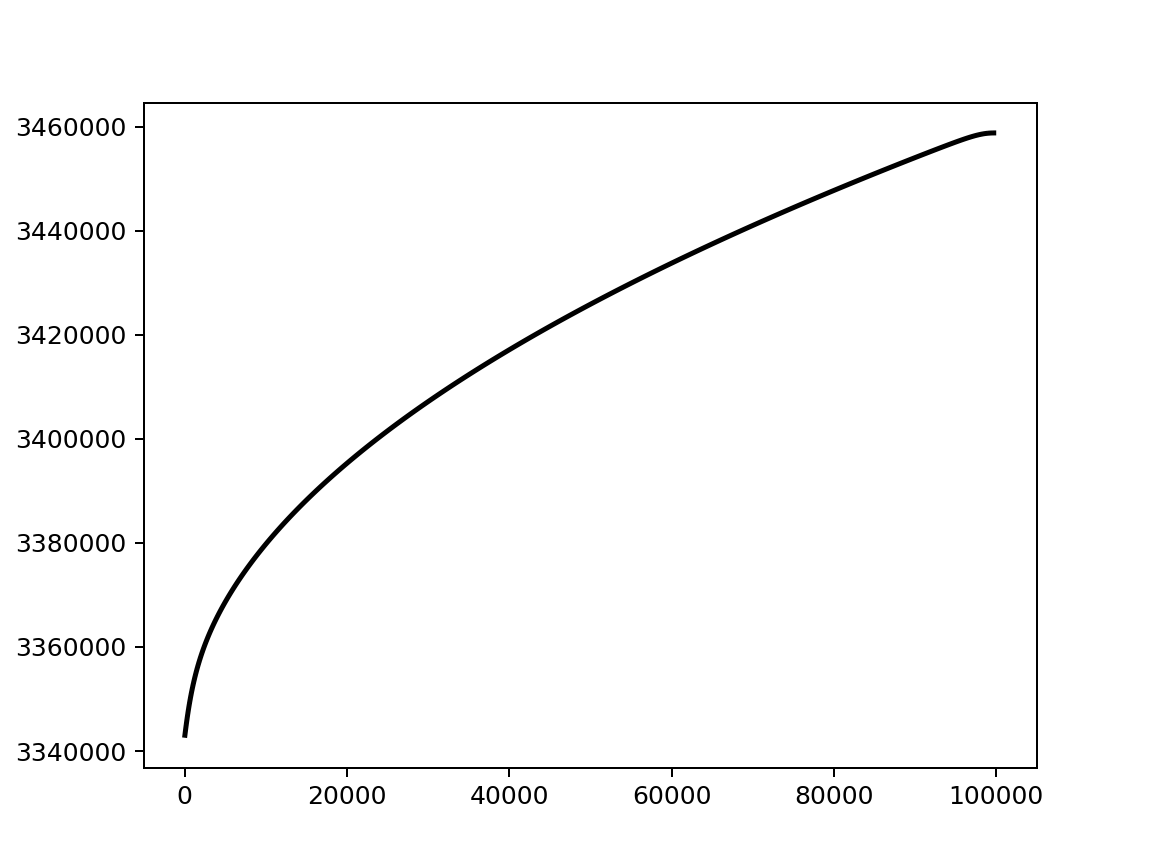

1729800.0
1731600.0
1733400.0
1735200.0
1737000.0
1738800.0
1740600.0
1742400.0
1744200.0
1746000.0
1747800.0
1749600.0
1751400.0
1753200.0
1755000.0
1756800.0
1758600.0
1760400.0
1762200.0
1764000.0
1765800.0
1767600.0
1769400.0
1771200.0
1773000.0
1774800.0
1776600.0
1778400.0
1780200.0
1782000.0
1783800.0
1785600.0
1787400.0
1789200.0
1791000.0
1792800.0
1794600.0
1796400.0
1798200.0
1800000.0
1801800.0
1803600.0
1805400.0
1807200.0
1809000.0
1810800.0
1812600.0
1814400.0


<IPython.core.display.Javascript object>


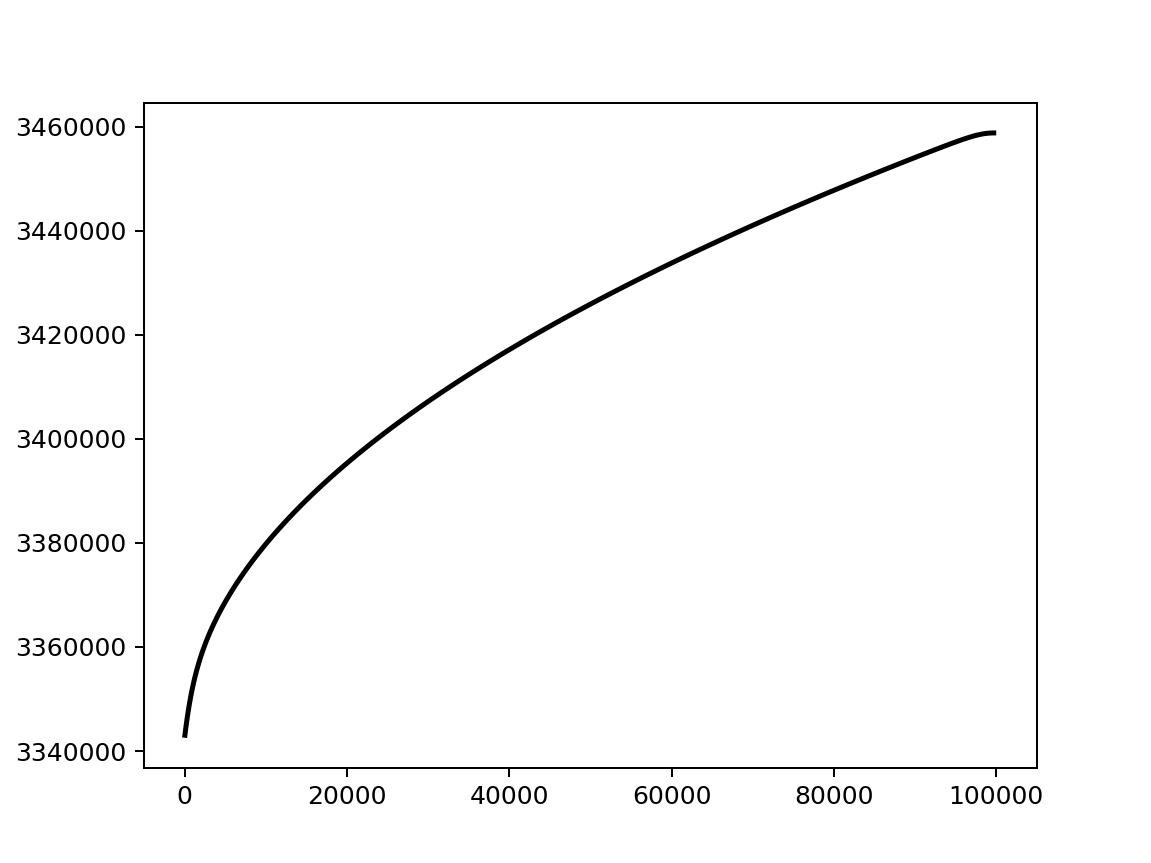

1816200.0
1818000.0
1819800.0
1821600.0
1823400.0
1825200.0
1827000.0
1828800.0
1830600.0
1832400.0
1834200.0
1836000.0
1837800.0
1839600.0
1841400.0
1843200.0
1845000.0
1846800.0
1848600.0
1850400.0
1852200.0
1854000.0
1855800.0
1857600.0
1859400.0
1861200.0
1863000.0
1864800.0
1866600.0
1868400.0
1870200.0
1872000.0
1873800.0
1875600.0
1877400.0
1879200.0
1881000.0
1882800.0
1884600.0
1886400.0
1888200.0
1890000.0
1891800.0
1893600.0
1895400.0
1897200.0
1899000.0
1900800.0


<IPython.core.display.Javascript object>


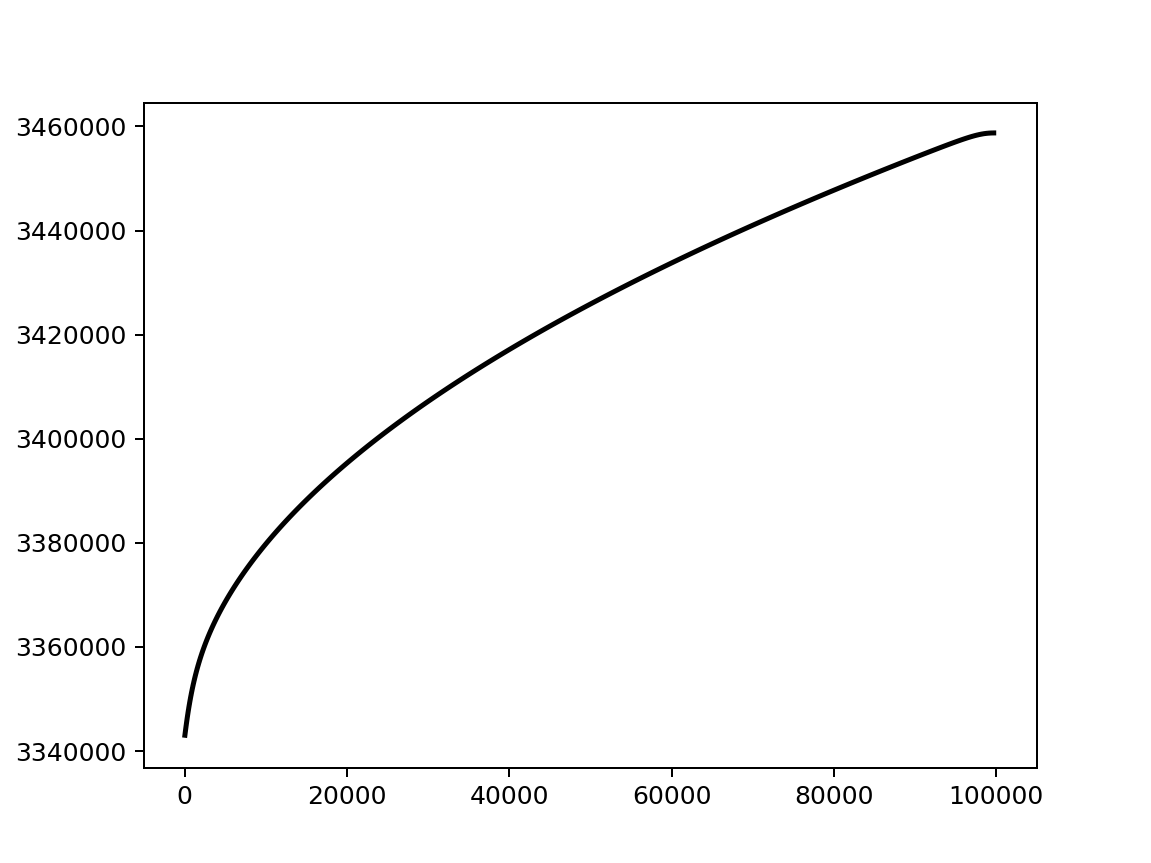

1902600.0
1904400.0
1906200.0
1908000.0
1909800.0
1911600.0
1913400.0
1915200.0
1917000.0
1918800.0
1920600.0
1922400.0
1924200.0
1926000.0
1927800.0
1929600.0
1931400.0
1933200.0
1935000.0
1936800.0
1938600.0
1940400.0
1942200.0
1944000.0
1945800.0
1947600.0
1949400.0
1951200.0
1953000.0
1954800.0
1956600.0
1958400.0
1960200.0
1962000.0
1963800.0
1965600.0
1967400.0
1969200.0
1971000.0
1972800.0
1974600.0
1976400.0
1978200.0
1980000.0
1981800.0
1983600.0
1985400.0
1987200.0


<IPython.core.display.Javascript object>


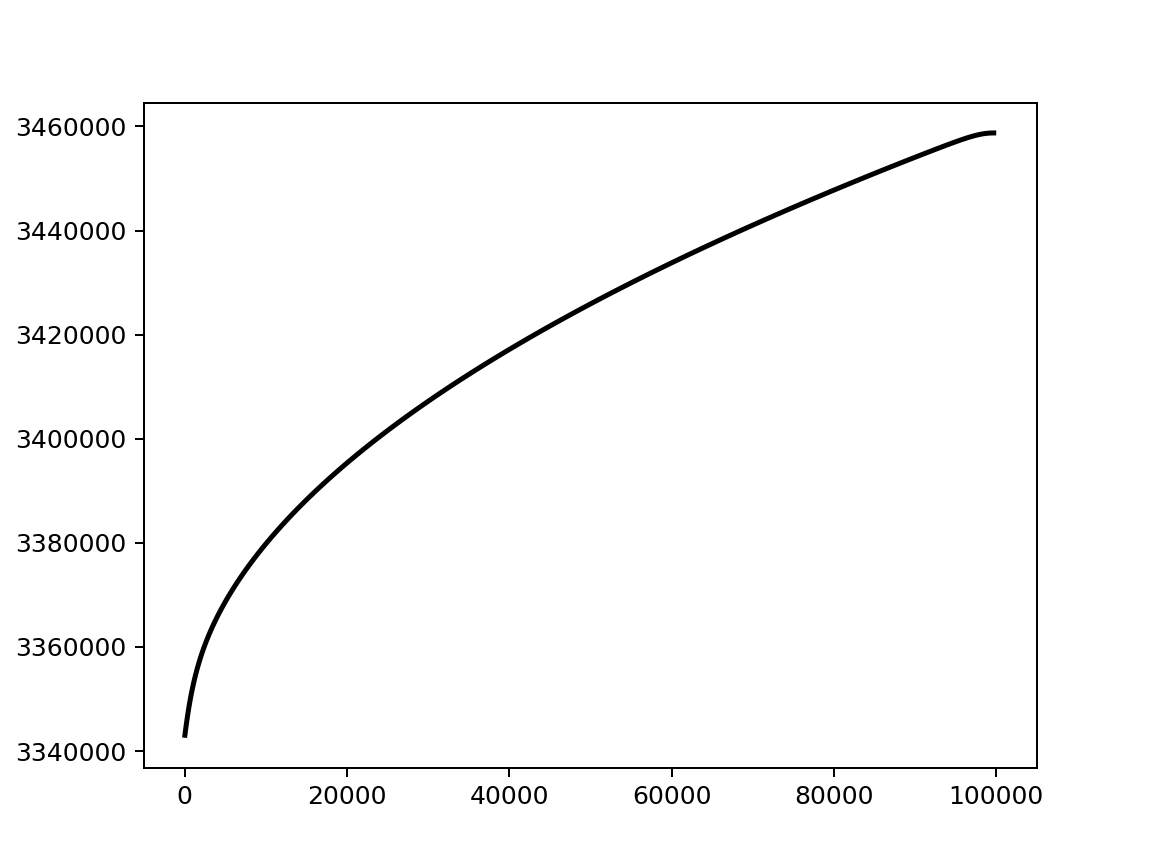

1989000.0
1990800.0
1992600.0
1994400.0
1996200.0
1998000.0
1999800.0
2001600.0
2003400.0
2005200.0
2007000.0
2008800.0
2010600.0
2012400.0
2014200.0
2016000.0
2017800.0
2019600.0
2021400.0
2023200.0
2025000.0
2026800.0
2028600.0
2030400.0
2032200.0
2034000.0
2035800.0
2037600.0
2039400.0
2041200.0
2043000.0
2044800.0
2046600.0
2048400.0
2050200.0
2052000.0
2053800.0
2055600.0
2057400.0
2059200.0
2061000.0
2062800.0
2064600.0
2066400.0
2068200.0
2070000.0
2071800.0
2073600.0


<IPython.core.display.Javascript object>


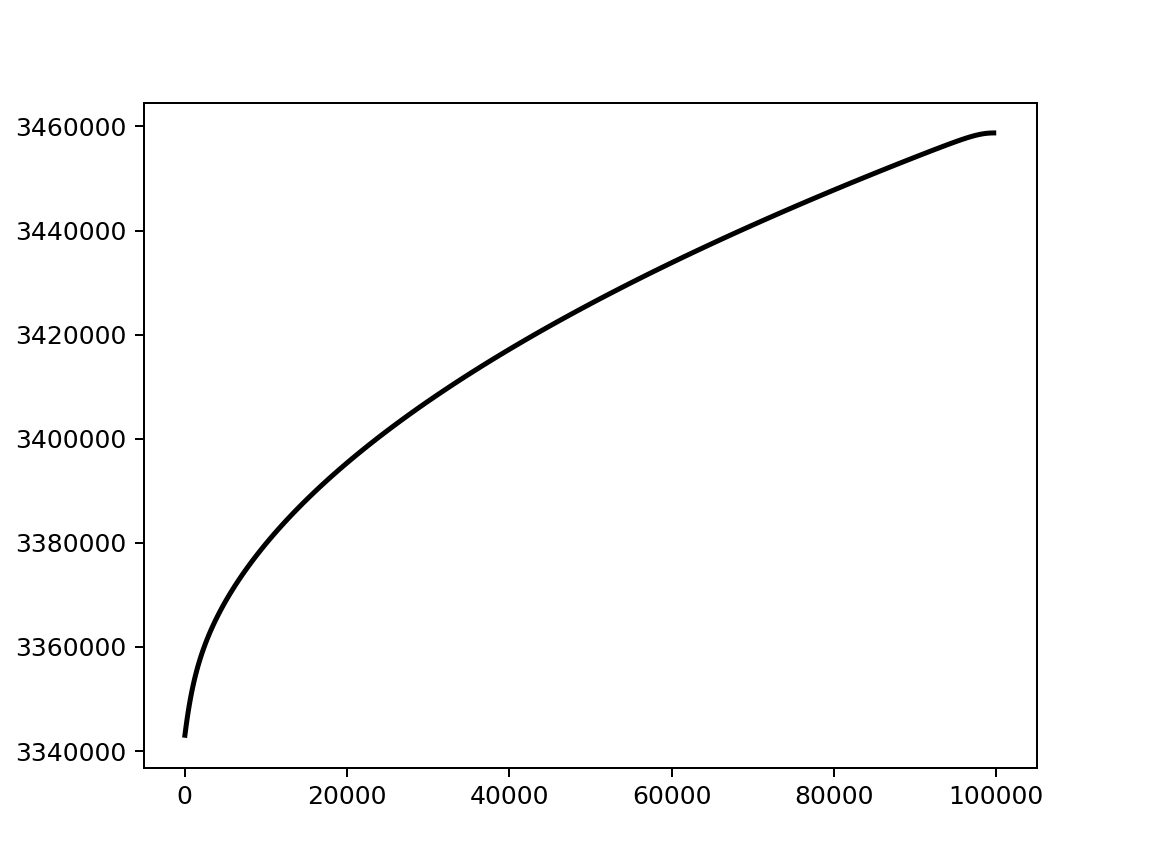

2075400.0
2077200.0
2079000.0
2080800.0
2082600.0
2084400.0
2086200.0
2088000.0
2089800.0
2091600.0
2093400.0
2095200.0
2097000.0
2098800.0
2100600.0
2102400.0
2104200.0
2106000.0
2107800.0
2109600.0
2111400.0
2113200.0
2115000.0
2116800.0
2118600.0
2120400.0
2122200.0
2124000.0
2125800.0
2127600.0
2129400.0
2131200.0
2133000.0
2134800.0
2136600.0
2138400.0
2140200.0
2142000.0
2143800.0
2145600.0
2147400.0
2149200.0
2151000.0
2152800.0
2154600.0
2156400.0
2158200.0
2160000.0


<IPython.core.display.Javascript object>


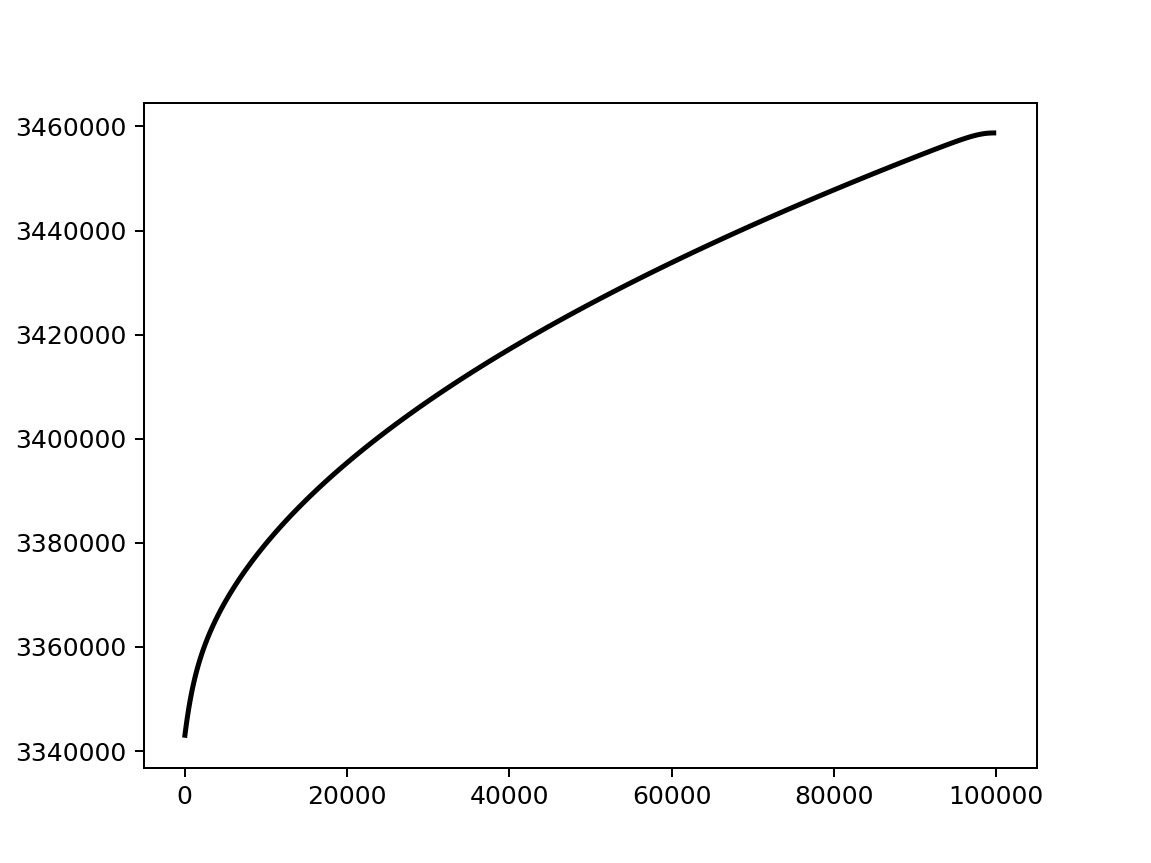

In [9]:
############# Run simulation ################

while model.t < T:
    model.step(dt)
    print(model.t)
    if (int(model.t) % 86400 ==0):
        plot(model.phi)

<IPython.core.display.Javascript object>


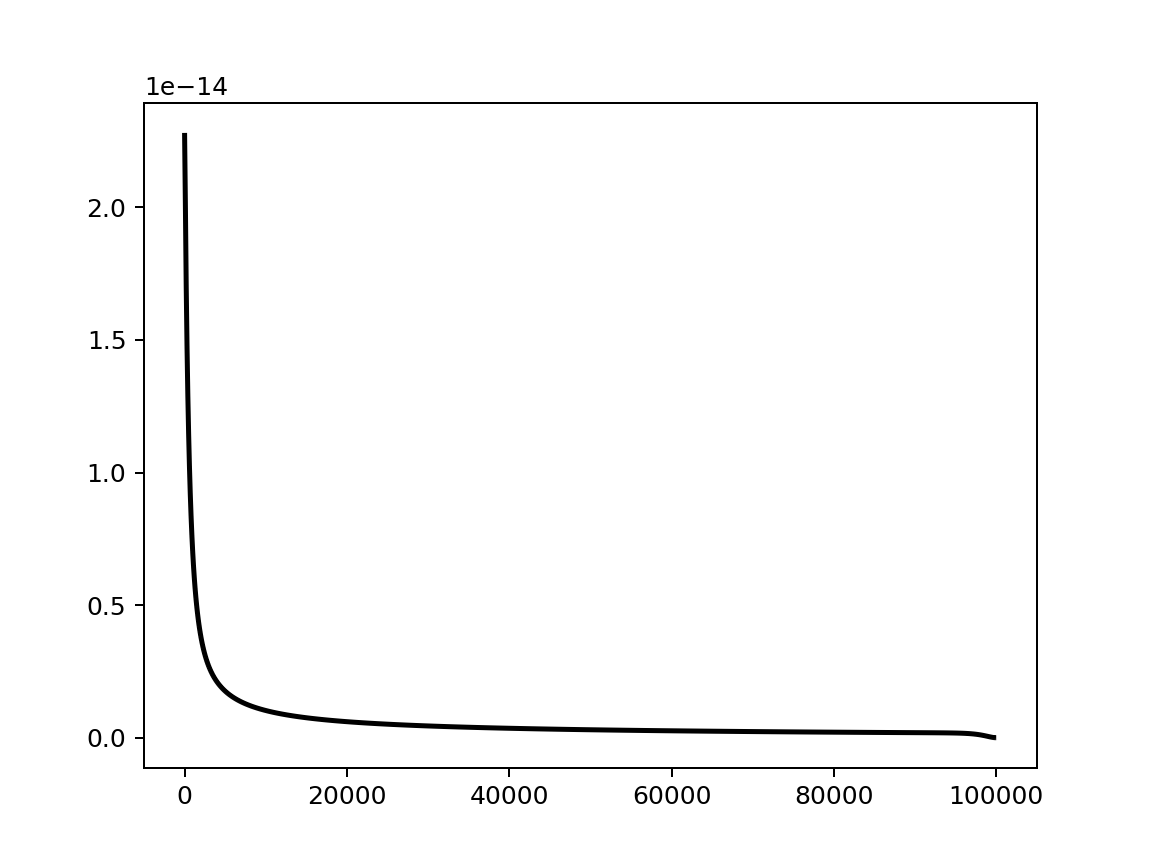

<IPython.core.display.Javascript object>


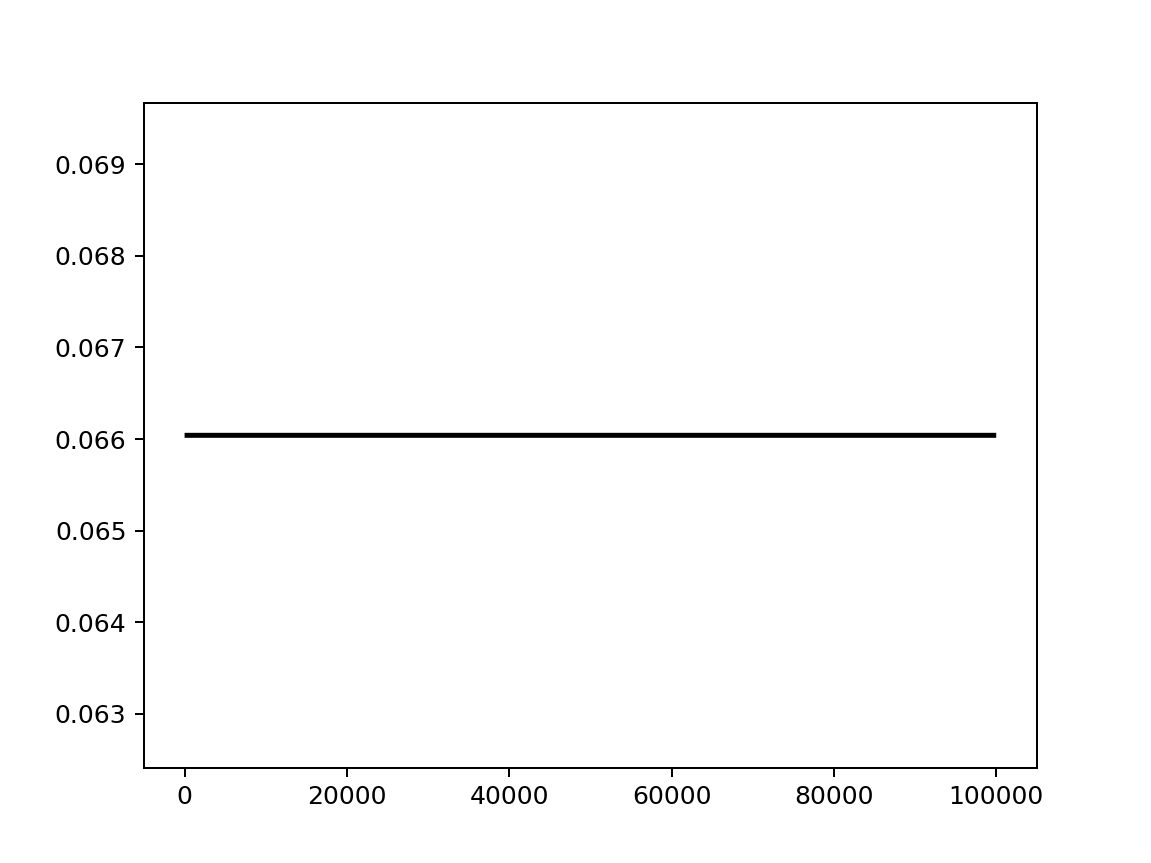

<IPython.core.display.Javascript object>


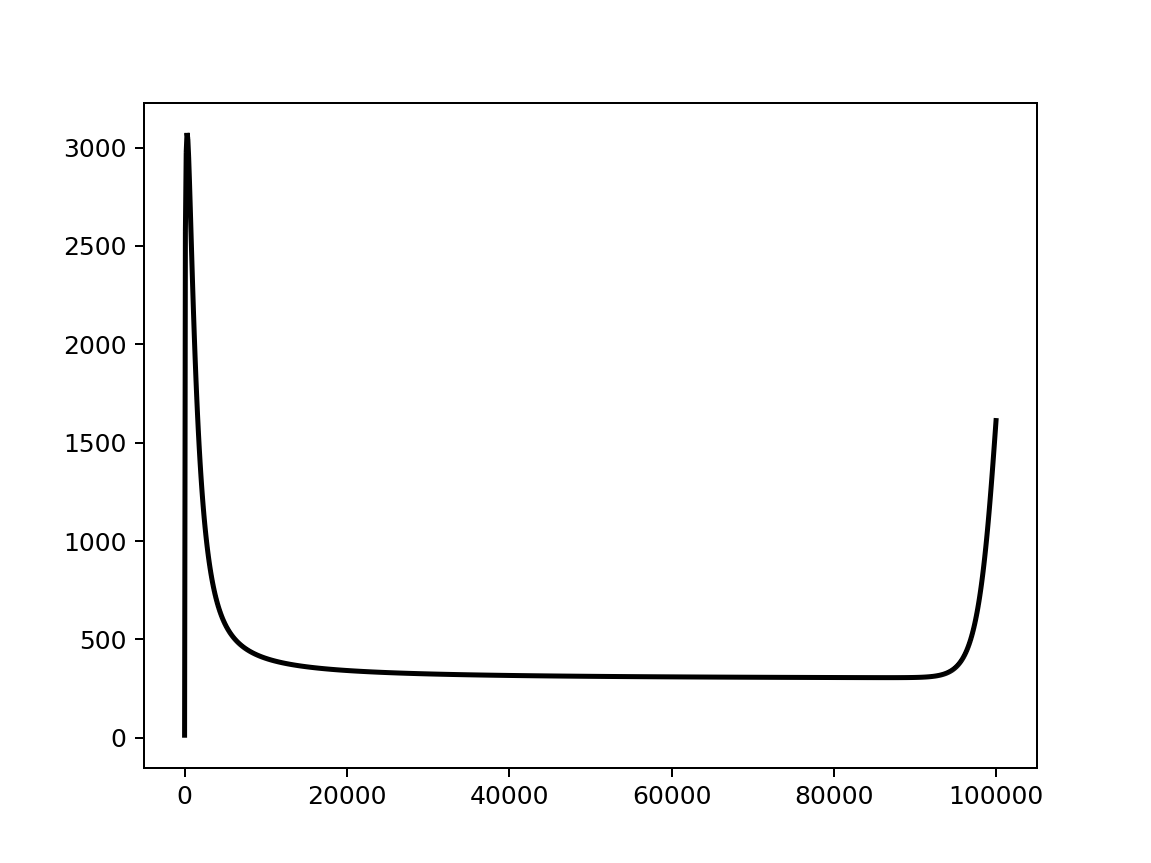

<IPython.core.display.Javascript object>


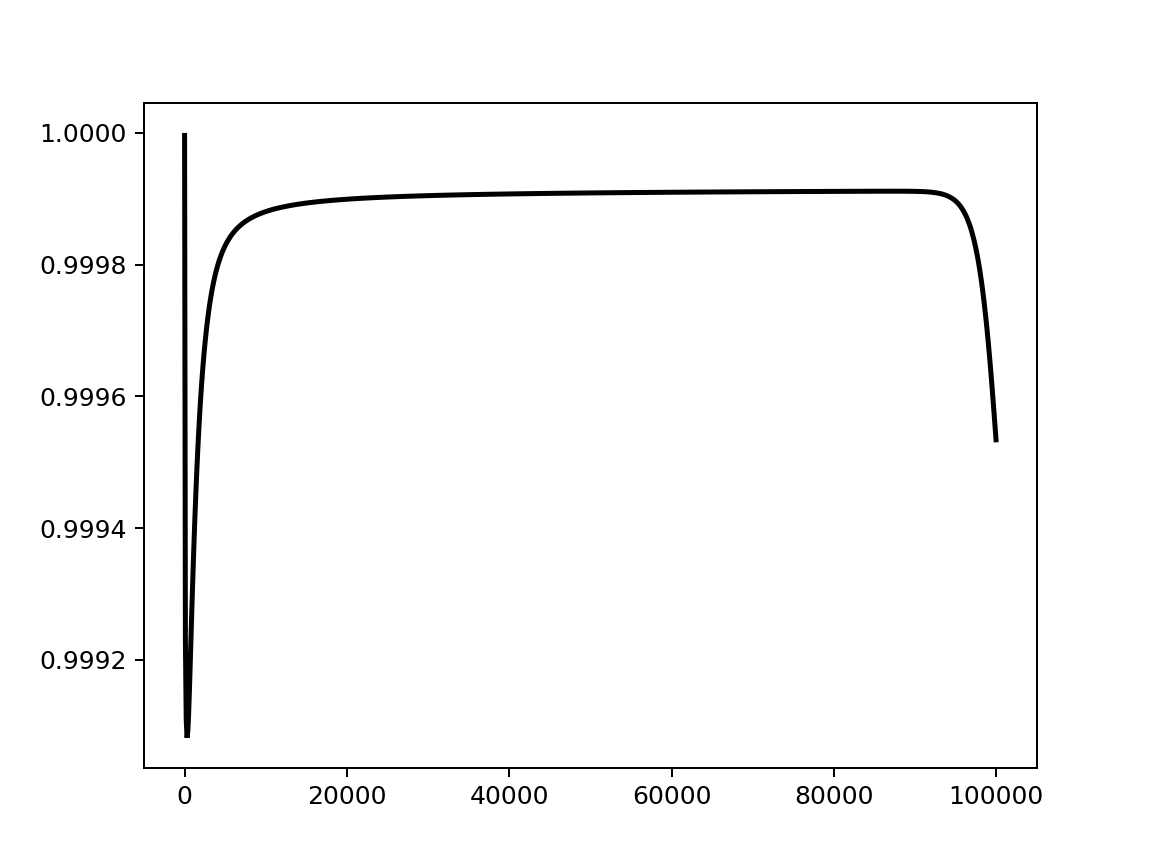

In [10]:
plot(model.S)
plot(model.h)
plot(model.N)
plot(model.pfo)

# Synthetic mountain glacier
This is another test that comes from the SHMIP experiment meant to represent the size and general character of Bench Glacier, AK. This is a 6km land terminating mountain glacier.

In [ ]:
########### Domain Geometry SHMIP part 2: Bench Glacier ############
proj_dir = '/Users/andrewhoffman/1Dhydrology/'

Lx = 6e3
nx =1000
b0=0.
W = 300.
flux_condition = 0.0
mesh = firedrake.IntervalMesh(nx,Lx)
degree = 1
V_cg = firedrake.FunctionSpace(mesh,"CG",degree)

In [ ]:
H=firedrake.Function(V_cg)
B=firedrake.Function(V_cg)
x = firedrake.SpatialCoordinate(mesh)
H=firedrake.interpolate(6*(firedrake.sqrt(firedrake.sqrt(x[0])+5000.)-firedrake.sqrt(firedrake.sqrt(5000.)))+firedrake.Constant(1.) ,V_cg)
B=firedrake.interpolate(firedrake.Constant(b0),V_cg)
width = firedrake.interpolate(firedrake.Constant(W),V_cg)
ub = firedrake.Function(V_cg)

#slip velocity and melt rate defined in the SHMIP experiment.
ub=firedrake.interpolate(firedrake.Constant(1e-6),V_cg)
m = firedrake.interpolate((firedrake.Constant(7.93e-11)),V_cg)

H_out = firedrake.File(proj_dir + "inputs/H.pvd")
B_out = firedrake.File(proj_dir + "inputs/B.pvd")

ub_out = firedrake.File(proj_dir + "inputs/ub.pvd")
m_out = firedrake.File(proj_dir + "inputs/m.pvd")

H_out.write(H)
B_out.write(B)
ub_out.write(ub)
m_out.write(m)